In [132]:
import numpy as np
import qinfer as qi
from functools import partial
import matplotlib.pyplot as plt
from sklearn import cluster as sk_cluster

%matplotlib inline
%run mfl_sensing_simplelib.py

print('[{}] Hi, jupyter ready. working dir: {}'.format(time.ctime(), os.getcwd()))
print("WARNING/TODO: broken for ramsey (non hahn/dd) experiments")

[Wed Aug  5 09:10:42 2020] Hi, jupyter ready. working dir: C:\Users\Timo\OneDrive\_Promotion\Software\MFL_repo
WARNING/TODO: broken for ramsey (non hahn/dd) experiments


# Preliminaries for the run

## Common parameters

In [125]:
%run mfl_sensing_simplelib.py

def set_common_params():
    global true_omega_1, true_omega_2, freq_min, freq_max, prior
    global t2star_s, true_params, n_particles
    global mfl_res_a, mfl_res_th
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global binarize_mode
    global exp_mode, hahn_b_gauss
    global phi_max
    global t2a_s, t2b_s
    global n_pi_dd_max, ndd_mod

    true_omega_1 =  2*np.pi*20e-3 #0.85   # here: A_par, MHz rad, 
    true_omega_2 =  2*np.pi*50e-3 #np.pi/2   # here: A_perp, MHz rad, 

    # the frequency boundaries for the starting prior
    #freq_min = 0.0
    freq_max = 2*np.pi*500e-3 # MHz rad
    freq_min = 0  # negative true_omega handled in build_initial_prior()
    freq_min_1 = None # restricting only first component
    phi_max = np.pi 
        
    t2star_s = 10e-6  # s
    t2a_s = 0
    t2b_s = 0
    true_params = np.array([[true_omega_1, true_omega_2]])

    # mfl params
    n_particles = 10000
    mfl_res_a = 0.98
    mfl_res_th = 0.7

    # noise
    noise_mode = None
    noise_c = 0.03
    noise_n_rep = 1e3
    noise_phot_0 = 0.04
    noise_phot_1 = 0.032
    
    # binarization
    binarize_mode = 'majority'
    
    # different pulsed experiments
    exp_mode = 'dd'
    hahn_b_gauss = 10
    n_pi_dd_max = 64
    ndd_mod = 2

set_common_params()


## MFL Lib

In [139]:
%run mfl_sensing_simplelib.py

def reset_result():
    global track_eval, track_cov, track_tau, track_loss, track_priors, track_errors, track_z, track_part, track_n
    global track_cluster, track_cluster_score, track_fi_diag
    global prior, model, updater, heuristic
    global mfl_res_a, mfl_res_th
    global safe_settings
    
    track_eval = [] # MHz rad
    track_cov = []  # MHz rad
    track_tau = []  # ns
    track_n = [] # order of dd
    track_z = [] # elements: (noisy val, real val, is_error, noisy binarized val, real binarized val)
    track_priors = [] # elements: (prior_as_array, idx_epoch)
    track_loss = []
    track_part = [] # elements: (particle_locations, particle weights)
    track_cluster = [] # elements: ([cluster_peaks (2d)], [cov (2d)], was_focus_invoked)
    track_cluster_score = [] # elements: dict('score1': val, ...)
    track_fi_diag = [] # elements: fi_par, fi_perp (diag elements only)
    
    safe_settings = {'safe_enabled': False}
    #model = ExpDecoKnownPrecessionModel(min_freq= freq_min, invT2= 1/(t2star_s*1e6))
    # resetting updater&heuristic for ease of multiple calls to this cell
    #updater = basic_SMCUpdater(model, n_particles, prior, resample_a=mfl_res_a, resample_thresh=mfl_res_th)
    #updater.reset()
    #heuristic = stdPGH(updater, inv_field='w_')

def get_params():
    global mfl_res_a, mfl_res_th
    global true_omega_1, true_omega_2, freq_min, freq_max, phi_max, prior
    global t2star_s, true_params, n_particles
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global binarize_mode
    global t2a_s, t2b_s, n_pi_dd_max
    global n_pi_dd_max, ndd_mod
    
   
    
    ret_dict = {'mfl_res_a': mfl_res_a, 'mfl_res_th':mfl_res_th,
               'true_omega_1': true_omega_1, 'true_omega_2': true_omega_2, 'freq_min': freq_min, 'freq_min_1': freq_min_1,
                'freq_max': freq_max,
                'phi_max': phi_max,
                't2star_s': t2star_s, 'n_particles':n_particles,
                'noise_mode': noise_mode, 'noise_c': noise_c, 'noise_n_rep': noise_n_rep,
                'noise_photons_0': noise_phot_0, 'noise_photons_1': noise_phot_1,
                'binarize_mode': binarize_mode,
                'exp_mode': exp_mode, 'hahn_b_gauss': hahn_b_gauss, 't2_a_dd_s': t2a_s, 't2_b_dd_s': t2b_s, 
                'n_pi_dd_max': n_pi_dd_max, 'n_dd_mod': ndd_mod}

    
    return ret_dict

def enable_safe(savepath):
    import os
    
    safe_settings['safe_enabled'] = True
    safe_settings['savepath'] = savepath
    
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    
    
    print("Save enabled to {}".format(savepath))

def get_safe_enabled():
    if safe_settings['safe_enabled']:
        return safe_settings['safe_enabled'], safe_settings['savepath'] 
    else:
        return (False, "")

def save_notebook(dir_global_scope):
    import shelve
    
    accept_types = [np.ndarray, str, bool, float, int, list, tuple]
    def to_dict(obj):
        mdict = {}
        accept_types = [np.ndarray, str, bool, float, int, list, tuple]

        if type(obj) is dict:
            d = obj
        else: # convert generic object to dict
            d = obj.__dict__

        for key, var in d.items():
            if type(var) in accept_types:
                mdict[key] = var
            # clear up subdicts from non accepted types
            if type(var) is dict:
                #print("Debug: to dict of:{} ".format(key))
                mdict[key] = to_dict(var)
        
        return mdict
    

    
    if safe_settings['safe_enabled'] == True:
        # save all globals and code to shelve file
        filename = safe_settings['savepath'] + '/' + 'nb_vars.shelve'
        my_shelf = shelve.open(filename,'n') 
        for key in dir_global_scope:
            try:
                if type(globals()[key]) in accept_types:
                    my_shelf[key] = globals()[key]
            except TypeError:
                pass
                # __builtins__, my_shelf, and imported modules can not be shelved
                #print('ERROR shelving: {0}'.format(key))
        my_shelf.close()
        
        # all variables to text json file
        import json
        filename = safe_settings['savepath'] + '/' + 'nb_vars.json'
        
        save_dict = {}
        for key in dir_global_scope:
            # need to filter out weird ipython internals
            if key.startswith('_i') or key.startswith('_oh') or key.startswith('_') or key is 'Out' or key is 'In':
                continue
            try:
                save_dict[key] = globals()[key]
            except TypeError:
                pass
        
        #print(save_dict.keys())
        save_dict_2 = to_dict(save_dict)
        #print("After: {}".format(save_dict_2.keys()))
        
        def convert_ndarray(obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            raise TypeError('Not serializable')
        
        with open(filename, 'w') as file:
            file.write(json.dumps(save_dict_2, default=convert_ndarray, indent=2))
            

def DEBUG_rand_z():
    import random
    return random.randint(0,1)

def plot_current_prior(label=None):
    #global prior, model, updater, from_heuristic
    # all particles
    #x = np.asarray(updater.particle_locations)
    #y = np.asarray(updater.particle_weights)
    #plt.scatter(x, updater.particle_weights, label=label)
    #plt.ylim(0, np.max(updater.particle_weights))
    #plt.legend()
    #plt.show()
    
    prior_arr = get_current_prior()
    plot_hist(prior_arr, label=label)

def plot_hist(data, label=None, n_bins=15, color=None):
    plt.hist(data, label=label, bins=n_bins, color=color)
    plt.legend()

    
def get_current_prior():
    global prior, model, updater, from_heuristic
    return updater.sample(n=updater.n_particles)

def binarize_result(z, **kwargs):
    if 'mode' in kwargs:
        mode = kwargs['mode']
        del kwargs['mode']
    else:
        mode = None
    if mode is None:
        mode = 'majority'
    
    # some noise models (eg Gaussian) may return non normed z
    if z<0:
        z = 0
    if z>1:
        z = 1
    
    if mode == 'majority':
        return majority_vote(z, **kwargs)
    elif mode == 'rand_coin':
        coin_res = rand_coin(z)  # balanced coin flip
        return coin_res

    else:
        raise AttributeError("Unknown binarize mode: {}".format(mode))

def majority_vote(z, z_thresh=0.5):
    if z > z_thresh:
        return 1
    else:
        return 0

def rand_coin(z):
    # majority vote randomized by a poissonian distribution
    coin_res = np.random.binomial(1, z)
    return coin_res
    
def exp_result(model, true_params, experiment, n_sweeps=1):
    res_list = []
    # todo: n_sweeps like this shouldn't make any difference for ideal case!
    if n_sweeps > 1:
        raise RuntimeError("Shouldn't use this anymore. No difference for ideal case. Noise handled differently!")
    for i in range(0, n_sweeps):
        res_no_noise = []
        res_list.append(model.simulate_experiment(true_params, experiment, full_result=True))
        z_real = res_list[-1]
    
    avg = np.average(np.asarray(res_list))
    #print("debug: ramsey: average {} of n_sweeps= {}".format(avg, n_sweeps))
    return avg, z_real

def build_simulation_model():
    global noise_mode
    global t2star_s, freq_min
    global exp_mode
    global freq_min
    
    if t2star_s != 0.:
        inv_T2 = 1/(1e6*t2star_s)
    else:
        inv_T2 = 0
    
    
    if exp_mode is 'ramsey':
        if noise_mode is None:
            if t2star_s != 0:
                model = ExpDecoKnownMultimodePrecModel(min_freq=0, inv_T2=inv_T2)
            else:
                model = MultimodePrecModel(min_freq=0)
        else:
            raise RuntimeError("Invalid noise mode: {}".format(noise_mode))
    elif exp_mode is 'hahn':
        model = MultimodeHahnModel(b_gauss=hahn_b_gauss)
        if noise_mode is not None:
            print("Warning: noise mode {} not implemented. Continuing without noise.".format(noise_mode))
    elif exp_mode is 'dd':
        if true_omega_1 >= 0 and true_omega_2 >= 0:
            model = MultimodeDDModel(b_gauss=hahn_b_gauss, T2_a=t2a_s, T2_b=t2a_s, min_freq=0)
        elif true_omega_1 < 0:
            model = MultimodeDDModel(b_gauss=hahn_b_gauss, T2_a=t2a_s, T2_b=t2a_s, min_freq=-freq_max) # negative A_par
        else:
            raise NotImplementedError
        
        if noise_mode is not None:
            print("Warning: noise mode {} not implemented. Continuing without noise.".format(noise_mode))
    else:
        raise ValueError("Unknown experiment: {}".format(exp_mode))
    
    return model

def build_heuristic():
    heuristic = None
    global exp_mode
    global hahn_b_gauss
    global true_omega_0, true_omega_1
    global heuristic_2
        
    if exp_mode is 'ramsey':
        if t2star_s != 0:
            heuristic = T2RandPenalty_MultiPGH(updater, tau_thresh_rescale=t2star_s/4, scale_f=4, inv_field=['w1','w2'],                                        )
        else:
            heuristic = MultiPGH(updater, inv_field=['w1','w2'])
    elif exp_mode is 'hahn':
        heuristic = MultiHahnPGH(updater, hahn_b_gauss, inv_field=['w1','w2'])
    elif exp_mode is 'dd':
        #heuristic = MultiDDPGH(updater, hahn_b_gauss, inv_field=['w1','w2'])
        #heuristic = MultiDD_EstAOptFish_PGH(updater, hahn_b_gauss, inv_field=['w1','w2'], n_pi_max=n_pi_dd_max, opt_mode='rand')
        #heuristic = MultiDD_EstAOptFish_PGH(updater, hahn_b_gauss, inv_field=['w1','w2'], n_pi_max=n_pi_dd_max,
        #                                    opt_mode='fi_trace', restr_ndd_mod=ndd_mod)
        heuristic = MultiDD_EstAnResOptFish_PGH(updater, hahn_b_gauss, inv_field=['w1','w2'], n_pi_max=n_pi_dd_max,
                                            opt_mode='fi_trace', restr_ndd_mod=ndd_mod)
        #heuristic = MultiDD_EstResnUncOptFish1d_PGH(updater, hahn_b_gauss, inv_field=['w1','w2'], n_pi_max=n_pi_dd_max,
        #                                    opt_mode='fi_trace', restr_ndd_mod=ndd_mod)
        #heuristic._cheat_w_true = [true_omega_1, true_omega_2]
        #print("Waning: Using cheat true omega in heursitc")
        #heuristic = MultiDD_EstAOptFish_EigenPGH(updater, hahn_b_gauss, inv_field=['w1','w2'], n_pi_max=n_pi_dd_max, rand_opt_par_perp=True)
        #heuristic = MultiDD_EstAPlaceAtDip_PGH(updater, hahn_b_gauss, inv_field=['w1','w2'])
        
        heuristic._calc_fi_mode = 'precise_1'
    else:
        raise ValueError("Unknown experiment: {}".format(exp_mode))
    
    return heuristic

def build_initial_prior():
    global exp_mode
    #guess_init = [freq_max/2, freq_max/2]
    #guess_init = [2*np.pi*1.5, 2*np.pi*1.5]
    #guess_init_cov = [[freq_max/2,0],[0,freq_max/2]]
    #prior = qi.MultivariateNormalDistribution(guess_init, guess_init_cov)
    if exp_mode is 'hahn':
        prior = qi.UniformDistribution(np.asarray([[freq_min, freq_max],[0, phi_max]]))
    elif exp_mode is 'ramsey':
        prior = qi.UniformDistribution(np.asarray([[freq_min, freq_max],[freq_min, freq_max]]))
    if exp_mode is 'dd':
        if true_omega_1 >= 0 and true_omega_2 >= 0:
            prior = qi.UniformDistribution(np.asarray([[freq_min, freq_max],[freq_min, freq_max]]))
        elif true_omega_1 < 0 and true_omega_2 >= 0:
            if freq_min_1 is None:
                prior = qi.UniformDistribution(np.asarray([[-freq_max, -freq_min],[freq_min, freq_max]])) # negative A_par
            else:
                prior = qi.UniformDistribution(np.asarray([[-freq_max, -freq_min_1],[freq_min, freq_max]])) # negative A_par
        else:
            raise NotImplementedError
    else:
        raise ValueError("Unknown experiment: {}".format(exp_mode))
    #print("DEBUG: Initial guess {} +- {} MHz".format(np.asarray(guess_init)/(2*np.pi), np.asarray(guess_init_cov)/(2*np.pi)))    
   
    
    return prior

def eval_loss(
        model, est_mean, true_mps=None,
        true_model=None, true_prior=None
    ):
    
    if true_model is None:
        true_model = model

    if true_mps is None:
        true_mps = true_model.update_timestep(
            promote_dims_left(true_mps, 2), expparams)[:, :, 0]

    if model.n_modelparams != true_model.n_modelparams:
        raise RuntimeError("The number of Parameters in True and Simulated model are different.")
                           
    n_pars = model.n_modelparams

    delta = np.subtract(*qi.perf_testing.shorten_right(est_mean, true_mps))
    loss = np.dot(delta**2, model.Q[-n_pars:])

    return loss


def prior_erase_mirrored(updater):
    #particles = [updater.particle_locations, updater.particle_weights]
    # by definition w2 > w1
    
    prior_erase_out_of_limits(updater)
  
    updater.particle_weights[updater.particle_locations[:,1] < updater.particle_locations[:,0]] = 0
    #print(particles[0])
    #print(particles[1])
    pass

def prior_erase_out_of_limits(updater):
    #particles = [updater.particle_locations, updater.particle_weights]
    # by definition w2 > w1
    
    if true_omega_1 >= 0 and true_omega_2 >= 0:

        updater.particle_weights[updater.particle_locations[:,0] < freq_min] = 0
        updater.particle_weights[updater.particle_locations[:,0] > freq_max] = 0
        updater.particle_weights[updater.particle_locations[:,1] < freq_min] = 0
        updater.particle_weights[updater.particle_locations[:,1] > freq_max] = 0

    elif true_omega_1 < 0:
        updater.particle_weights[updater.particle_locations[:,0] > freq_min] = 0
        updater.particle_weights[updater.particle_locations[:,0] < -freq_max] = 0
        updater.particle_weights[updater.particle_locations[:,1] < freq_min] = 0
        updater.particle_weights[updater.particle_locations[:,1] > freq_max] = 0
        
        if freq_min_1 is not None:
            updater.particle_weights[updater.particle_locations[:,0] > -freq_min_1] = 0
        
    else:
        raise NotImplementedError
    
def run_estimation(n_epochs=25, n_sweeps=1, i_split_exp=50, recur_cluster=None):
    
    global prior, model, updater, heuristic
    global noise_mode, noise_c, noise_n_rep, noise_phot_0, noise_phot_1
    global true_params
    
    # the expected T2*, when 0 this is the ideal case
    if t2star_s != 0.:
        inv_T2 = 1/(1e6*t2star_s)
    else:
        inv_T2 = 0
    
    prior = build_initial_prior()
    model = build_simulation_model()
    
    # resetting updater&heuristic for ease of multiple calls to this cell
    updater = basic_SMCUpdater(model, n_particles, prior, 
                               resample_a=mfl_res_a, resample_thresh=mfl_res_th)
    
    heuristic = build_heuristic()
    print("WARNING: Using prior_erase_mirrorer(), actually wrong!")
    
    #print("DEBUG: Starting to run with: {}, {}, {}, {}".format(prior, model, updater, heuristic))
    
    for idx_epoch in range(n_epochs):
        #  we call the heuristic to generate a time,
        experiment = heuristic()
        """
        if idx_epoch < 50:
            experiment = heuristic()
        else:
            print("DEBUG: switching heuristic")
            experiment = heuristic_2()
        # DEBUG only experiment['t'] = idx_epoch + 1
        """
        tau = experiment['t']
        n_dd = experiment['n']
        #print("tau: {} us".format(tau))
        
        track_priors.append((get_current_prior(), idx_epoch))
         
        # result as sig_z with and w/o noise
        datum, datum_no_noise = exp_result(model, true_params, experiment, n_sweeps=n_sweeps)
        datum_bin, datum_no_noise_bin = binarize_result(datum, mode=binarize_mode), binarize_result(datum_no_noise, mode=binarize_mode)
        is_error = (datum_bin != datum_no_noise_bin)
        track_z.append([datum, datum_no_noise, is_error, datum_bin, datum_no_noise_bin])
          
        # we invoke the updater method to update the estimate according to the last datum and time chosen
        #experiment['w_'] = 0
        updater.update(datum_bin, experiment)
            
        particles = [updater.particle_locations, updater.particle_weights]
        
        prior_erase_out_of_limits(updater)
        prior_erase_mirrored(updater)
        
        """
        peaks, cov, score = cluster_2d(particles)
        was_focus_invoked = False
        #if _start_clustering(idx_epoch, i_split_exp, recur_cluster):
        if _auto_clusterstart(idx_epoch - 1, req_mirrored_detect=True):    
            updater, _ = focus_single_cluster(peaks, cov)
            heuristic = T2RandPenalty_MultiPGH(updater, tau_thresh_rescale=t2star_s/4, scale_f=4, inv_field=['w1','w2'],
                                               )
            was_focus_invoked = True
            print("Invoked clustering at epoch {}. Clustered peaks {} MHz +- {} MHz".format(
                idx_epoch, np.asarray(peaks)/(2*np.pi), np.sqrt(np.asarray(cov))))
        """ 
        # here we just append our latest estimate and error estimate to the list of estimates
        track_tau.append(tau*1e3) # us -> ns
        track_n.append(n_dd) # us -> ns
        new_eval = updater.est_mean()
        track_eval.append(new_eval)  # MHz rad
        track_cov.append( np.sqrt( abs(np.nan_to_num(updater.est_covariance_mtx()))))  # actually: std dev, off diagonals abs()
        track_loss.append(eval_loss(model, new_eval, true_params)[0])
        track_part.append(particles)
        try:
            track_fi_diag.append(heuristic.calc_fisher_information_at_A(new_eval[0]/(2*np.pi), new_eval[1]/(2*np.pi), tau, n_dd))
        except:
            pass
        if idx_epoch % 100 == 0:
            print("Epoch {}, t_tot: {} us".format(idx_epoch, n_dd*tau))
        #track_cluster.append([peaks, cov, was_focus_invoked])
        #track_cluster_score.append(score)
            
    return (track_tau, track_eval, track_cov, track_priors)

def get_likelihood(idx_epoch, omega_mhzrad_1, omega_mhzrad_2, exp_outcome=0):
    global model, updater
    
    locs = np.zeros([len(omega_mhzrad_1), 2]) #updater.particle_locations
    locs[:, 0] = omega_mhzrad_1
    locs[:, 1] = omega_mhzrad_2
    
    expparams = np.empty((1,), dtype=[('t', '<f8'), ('n', '<i4'), ('w1', '<f8'), ('w2', '<f8')])  # tau (us)
    expparams['t'] = track_tau[idx_epoch]*1e-3
    expparams['n'] = track_n[idx_epoch]
    expparams['w1'] = 0
    expparams['w2'] = 0
    
    y = model.likelihood(exp_outcome, locs, expparams).transpose([0, 2, 1]).transpose()[:,0,0]
    
    #plt.scatter(locs, y)
    #plt.show()
    
    return locs, y    # MHz   

def get_likelihood_vs_w(tau_s, n, omega_mhzrad_1, omega_mhzrad_2, exp_outcome=0, b_gauss=500):
        
    locs = np.zeros([len(omega_mhzrad_1), 2]) #updater.particle_locations
    locs[:, 0] = omega_mhzrad_1
    locs[:, 1] = omega_mhzrad_2
    
    expparams = np.empty((1,), dtype=[('t', '<f8'), ('n', '<i4'), ('w1', '<f8'), ('w2', '<f8')])  # tau (us)
    expparams['t'] = tau_s*1e6
    expparams['n'] = n
    expparams['w1'] = 0
    expparams['w2'] = 0
    
    model = MultimodeDDModel(b_gauss=b_gauss)
    y = model.likelihood(exp_outcome, locs, expparams).transpose([0, 2, 1]).transpose()[:,0,0]
    
    #plt.scatter(locs, y)
    #plt.show()
    
    return locs, y    # MHz   
    

def get_p_vs_t(tau, omega_mhz_1, omega_mhz_2, n_dd=4, exp_outcome=0, b_gauss=100,
              t2_a=0, t2_b=0):
    model = MultimodeDDModel(b_gauss=b_gauss, T2_a=t2_a, T2_b=t2_b)
    
    locs = np.zeros([1, 2]) #updater.particle_locations
    locs[0, 0] = omega_mhz_1*2*np.pi
    locs[0, 1] = omega_mhz_2*2*np.pi
    
    expparams = np.empty((1,), dtype=[('t', '<f8'), ('n', '<i4'), ('w1', '<f8'), ('w2', '<f8')])  # tau (us)
    p = np.zeros(len(tau))
    
    # serial calculation will be slow!
    for i, t in enumerate(tau):  # [tau] = s
        expparams['t'] = t*1e6
        expparams['n'] = n_dd
        expparams['w1'] = 0
        expparams['w2'] = 0

        p[i]= (model.likelihood(exp_outcome, locs, expparams).transpose([0, 2, 1]).transpose()[:,0,0])
        
    #plt.scatter(locs, y)
    #plt.show()
    
    return p    # MHz   

def get_p_vs_n(n_dd, omega_mhz_1, omega_mhz_2, tau=1e-6, exp_outcome=0, b_gauss=100,
              t2_a=0, t2_b=0):
    model = MultimodeDDModel(b_gauss=b_gauss, T2_a=t2_a, T2_b=t2_b)
    
    locs = np.zeros([1, 2]) #updater.particle_locations
    locs[0, 0] = omega_mhz_1*2*np.pi
    locs[0, 1] = omega_mhz_2*2*np.pi
    
    expparams = np.empty((1,), dtype=[('t', '<f8'), ('n', '<i4'), ('w1', '<f8'), ('w2', '<f8')])  # tau (us)
    p = np.zeros(len(n_dd))
    
    # serial calculation will be slow!
    for i, n in enumerate(n_dd):  # [tau] = s
        expparams['t'] = tau*1e6
        expparams['n'] = n
        expparams['w1'] = 0
        expparams['w2'] = 0

        p[i]= (model.likelihood(exp_outcome, locs, expparams).transpose([0, 2, 1]).transpose()[:,0,0])
        
    #plt.scatter(locs, y)
    #plt.show()
    
    return p    # MHz  

def est_tau_res(A_par_mhz, B_gauss, k_order=1):
    return heuristic.calc_tau_k(A_par_mhz, k_order, no_warning=True, b_gauss=B_gauss)
 

def plot_result():
    #print(track_eval[-1], track_cov[-1])
    
    # est(B), dB
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    x = range(0, len(track_eval))
    
    y_1 = np.asarray([val[0] for val in track_eval])/(2*np.pi)
    y_2 = np.asarray([val[1] for val in track_eval])/(2*np.pi)
    dy_1 = np.asarray([el[0][0] for el in track_cov])/(2*np.pi)
    dy_2 = np.asarray([el[1][1] for el in track_cov])/(2*np.pi)
    if exp_mode is 'hahn':
        y_1 = np.asarray([val[0] for val in track_eval])
        y_2 = np.asarray([val[1] for val in track_eval])/(np.pi)
        dy_1 = np.asarray([el[0][0] for el in track_cov])
        dy_2 = np.asarray([el[1][1] for el in track_cov])/(np.pi)
    
    label_1 = "est(f1)= {:.2f} Mhz".format(y_1[-1])
    label_2 = "est(f2)={:.2f} Mhz".format(y_2[-1])
    if exp_mode is 'hahn':
        label_1 = 'est(A)= {:.4f} MHz rad'.format(y_1[-1])
        label_2 = 'est(Phi)= {:.4f} rad/pi'.format(y_2[-1])
    
    plt.plot(y_1, label=label_1)
    plt.plot(y_2, label=label_2, color='orange')
    plt.fill_between(x, y_1-dy_1, y_1+dy_1, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF', antialiased=True)
    plt.fill_between(x, y_2-dy_2, y_2+dy_2, alpha=0.2, edgecolor='red', facecolor='yellow', antialiased=True)
    #plt.plot(dy, label='dB')
    
    label_1 = "f1= {:.2f} Mhz".format(true_omega_1/(2*np.pi))
    label_2 = "f2={:.2f} Mhz".format(true_omega_2/(2*np.pi))
    if exp_mode is 'hahn':
        label_1 = "A= {:.2f} MHz rad".format(true_omega_1)
        label_2 = "Phi= {:.2f} rad/pi".format(true_omega_2/(np.pi))
        
    if exp_mode is 'ramsey' or exp_mode is 'dd':
        plt.axhline(y=true_omega_1/(2*np.pi), label=label_1)
        plt.axhline(y=true_omega_2/(2*np.pi), label=label_2, color='orange')
    if exp_mode is 'hahn':                                               
        plt.axhline(y=true_omega_1, label=label_1)
        plt.axhline(y=true_omega_2/(np.pi), label=label_2, color='orange')
    plt.legend()
    axes = plt.gca()
    axes.set_ylabel('')
    
    plt.subplot(122)
    if exp_mode is 'hahn':
        y_ql = (y_1 - true_omega_1)**2
        y_q2 = (y_2 - true_omega_2/(np.pi))**2
    else:
        y_ql = (2*np.pi*y_1 - true_omega_1)**2
        y_q2 = (2*np.pi*y_2 - true_omega_2)**2
        
    plt.plot(y_ql)
    plt.plot(y_q2, color='orange')
    
    axes = plt.gca()
    axes.set_ylabel('quadratic losses (MHz^2)')
    axes.set_yscale('log')
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'mfl_result.png'
    if is_safe:
        plt.savefig(fname)
    plt.show()

def plot_scaling(t_evol=None, dB_mhz=None, errs=None, dB_mhz_scatter=None, tevol_scatter=None, n_rep=1)   :
   
    if t_evol is None:
        ns = np.asarray(track_n)
        taus = np.asarray(track_tau)*1e-9
        t_evol = np.multiply(taus, ns)
        
    tau_tot = calc_total_runtime(t_evol)
    if tevol_scatter is not None:
        tevol_tot_scatter = np.asarray([calc_total_runtime(run*n_rep) for run in tevol_scatter]).flatten()

    x = range(0, len(t_evol))
    if dB_mhz is None:
        dy = np.asarray([el[0][:] for el in track_cov])/(2*np.pi)
    else:
        dy = dB_mhz
    if errs is None:
        y_1 = np.asarray([val[0] for val in track_eval])/(2*np.pi)
        y_2 = np.asarray([val[1] for val in track_eval])/(2*np.pi)
        errs = []
        y_q1 = (2*np.pi*y_1 - true_omega_1)**2
        y_q2 = (2*np.pi*y_2 - true_omega_2)**2
        errs.append(y_q1)
        errs.append(y_q2)
    
    # est(B), dB
    plt.figure(figsize=(16, 4))
    plt.subplot(131)
    plt.plot(tau_tot, dy[:,0])
    plt.plot(tau_tot, dy[:,1])
    if tevol_scatter is not None and dB_mhz_scatter is not None:
        plt.scatter(tevol_tot_scatter, dB_mhz_scatter[:,0], s=3, marker='o', facecolors='none', alpha=0.5, edgecolors='C0')
        plt.scatter(tevol_tot_scatter, dB_mhz_scatter[:,1], s=3, marker='o', facecolors='none', alpha=0.5, edgecolors='C1')

    #plt.fill_between(x, y-dy, y+dy, alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    #                 antialiased=True)
    #plt.plot(dy, label='dB')
    #plt.axhline(y=true_omega/(2*np.pi), label="B= {:.4f} MHz".format(true_omega/(2*np.pi)))
    
    # fit to tail 
    n_epochs = len(x)
    n_points_fit = int(n_epochs/10)
    
    tau_log = np.log10(tau_tot)
    y_log = np.log10(dy[:,0])
    
    coefficients = np.polyfit(tau_log[-n_points_fit:], y_log[-n_points_fit:], 1)
    #print("DEBUG: n_epcohs, n_points_fit: {}, {}".format(n_epochs, n_points_fit))
    #print("DEBUG: tau_log, y_log: {}, {}".format(tau_log, y_log))
    #print("DEBUG: fit result: {}".format(coefficients))
    
    polynomial = np.poly1d(coefficients)
    ys = 10**polynomial(tau_log)
    n_plot_fit = int(0.95*len(tau_tot))
    plt.plot(tau_tot[-n_plot_fit:], ys[-n_plot_fit:], alpha=0.4,
             label='{:.2f} t + {:.2f}'.format(coefficients[0],coefficients[1]))
    
    plt.legend()
    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xlabel(r'$t_{\Phi,tot}$ /n_sweeps (s)')
    axes.set_yscale('log')
    axes.set_ylabel('dB (MHz)')
    
    plt.subplot(132)

    eta_phase = np.sqrt(tau_tot) * np.average(dy, axis=1)
    eta_phase_nT = eta_phase / (2.8*1e4)*1e9
    plt.plot(tau_tot, eta_phase_nT)
    if tevol_scatter is not None and dB_mhz_scatter is not None:
        dB_avg =  np.average(dB_mhz_scatter, axis=1).flatten()
        eta_scatter_nT = np.sqrt(tevol_tot_scatter)*dB_avg / (2.8*1e4)*1e9
        plt.scatter(tevol_tot_scatter, eta_scatter_nT, s=3, marker='o', facecolors='none', edgecolors='r', alpha=0.5)
    
    plt.legend()
    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xlabel(r'$t_{\Phi,tot}$ /n_sweeps (s)')
    axes.set_yscale('log')
    axes.set_ylabel(r'$\eta_{avg}$ (nT/sqrt(Hz))')
    if tevol_scatter is not None:
        axes.set_ylim([0.5,np.max(eta_scatter_nT)])
    
    
    
    plt.subplot(133)
    try:
        plt.plot(tau_tot, errs[0]**2)
        plt.plot(tau_tot, errs[1]**2)
    except:
        pass
    plt.legend()
    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xlabel(r'$t_{\Phi,tot}$ /n_sweeps (s)')
    axes.set_yscale('log')
    axes.set_ylabel(r'$QL$ (MHz^2)')
    
    plt.tight_layout()
    plt.show()
    
    
def plot_zs():
    global true_omega, binarize_mode
    global track_tau, track_z
    global exp_mode
    
    plt.figure(figsize=(14, 4))
    plt.subplot(131)
    
    tau_max = 1e-3*max(track_tau)[0]  # ns -> us
    t = np.linspace(0, tau_max, 250)
    
    # prepae input for likelihood
    expparams = np.zeros((len(t),), dtype=model.expparams_dtype)
    expparams['t'] = t  # us
    modelparams = np.zeros((1,2))
    modelparams[0,0] = true_omega_1 # for Ramsey: A (Mhz rad)
    modelparams[0,1] = true_omega_2 # for Ramsey: rad
    
    y_ideal = model.likelihood(None, modelparams, expparams)[0,0,:]
    #y_ideal = 1 - 0.5 * (np.cos(t * true_omega_1 / 2) ** 2 + np.cos(t * true_omega_2 / 2) ** 2)

    label = "{:.2f} Mhz / {:.2f} MHz".format(true_omega_1/(2*np.pi), true_omega_2/(2*np.pi))
    if exp_mode is 'hahn':
        label = "HE {:.2f} Mhz rad/ {:.2f} rad/pi".format(true_omega_1, true_omega_2/(np.pi))
        
    plt.plot(t, y_ideal, label=label)
    
   
    tau_corr_us = []
    tau_err_us = []
    z_bin_corr = []
    z_bin_err = []
    z_corr = []
    z_err = []
    z_err_corrected = []  # actually correct value
    z = [el[0] for el in track_z]
    tau = np.asarray(track_tau) *1e-3  # ns -> us
 

    for i, tau_i in enumerate(tau): 

        track_z_i = track_z[i]
        if track_z_i[2]: # is_error
            z_bin_err.append(track_z_i[3])
            tau_err_us.append(tau_i)
            z_err.append(track_z_i[0])
            z_err_corrected.append(track_z_i[1])
        else:
            z_bin_corr.append(track_z_i[3])
            tau_corr_us.append(tau_i)
            z_corr.append(track_z_i[0])
    
    print("DEBUG: len z_err {}, z_corr {}".format(len(z_err), len(z_corr)))
    plt.scatter(tau_err_us, z_err, label="sig_z wrong", color='red')
    plt.scatter(tau_corr_us, z_corr, label="sig_z")
    plt.scatter(tau_corr_us, z_bin_corr, label="z_bin", marker='s', s=12, alpha=0.8)
    plt.scatter(tau_err_us, z_bin_err, label="z_bin wrong", color='red', marker='s', s=12, alpha=0.8)
    plt.ylim([-0.2,1.2])
    plt.xlabel("tau (us)")
    plt.title("Binarize mode: {}".format(binarize_mode))
    
    plt.legend(bbox_to_anchor=(1, 0.8, 1.05, 0.2), loc="upper left", ncol=1)
    #plt.show()
    
    # vs epoch
    plt.subplot(132)
    plt.scatter(range(len(tau)), z_corr, label=label)
    plt.xlabel("epoch ()")
    
    # histogram of wrong z
    plt.subplot(133)
    plt.hist(z_err_corrected, bins=15, color='orange')
    plt.ylabel("Error votes")
    plt.xlabel("sig_z_correct")
    plt.xlim([0,1])
    plt.tight_layout()
    
    is_safe, path = get_safe_enabled()
    fname = path + '/' + 'mfl_zs.png'
    if is_safe:
        plt.savefig(fname)
            
    plt.show()
    
    #track_z
def plot_priors_2d_gaussian(epochs_idx=[]):
    global updater
    global track_part
    
    save_updater_locs, save_udpater_weights = updater.particle_locations, updater.particle_weights
    
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err=False)
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_part):
        epoch = i
        if epoch in epochs_idx:
            updater.particle_locations = track_part[epoch][0]
            updater.particle_weights = track_part[epoch][1]
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            line = updater.plot_posterior_contour()
            ax = plt.gca()
            
            label='Prior countour epoch {}'.format(epoch)
            plt.title(label)
            plt.xlabel("$\omega_1$ (MHz rad)")
            plt.ylabel("$\omega_2$ (rad/pi)")
            
            idx_plot += 1
        
    # reset
    updater.particle_locations, updater.particle_weights = save_updater_locs, save_udpater_weights
    
    plt.legend()
    
    is_safe, path = get_safe_enabled()
    fname = path + '/' + 'mfl_priors_2d.png'
    if is_safe:
        plt.savefig(fname)
            
    plt.show()
    
def plot_priors_2d_gaussian_heatmap(epochs_idx=[], n_bins=50, plot_likelihoods=False):
    global updater
    global track_part
    
    save_updater_locs, save_udpater_weights = updater.particle_locations, updater.particle_weights
    
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err=False)
    if plot_likelihoods:
        n_rows *= 2
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_part):
        epoch = i
        if epoch in epochs_idx:
            
            updater.particle_locations = track_part[epoch][0]
            updater.particle_weights = track_part[epoch][1]
            particle_locations = updater.particle_locations
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            line = plt.hist2d(particle_locations[:,0]/(2*np.pi), particle_locations[:,1]/(2*np.pi),
                              weights=updater.particle_weights, bins=n_bins)
            
            # mark clusters
            try:
                cluster_1 = track_cluster[epoch][0][0]
                cluster_2 = track_cluster[epoch][0][1]
                cov_1 = track_cluster[epoch][1][0]
                cov_2 = track_cluster[epoch][1][1]
                #center1 = plt.Circle(cluster_1, cov_1, color='r', fill=True)
                circle1 = plt.Circle(cluster_1, np.sqrt(cov_1), color='r', fill=False)
                circle2 = plt.Circle(cluster_2, np.sqrt(cov_2), color='r', fill=False)

                ax = plt.gca()
                ax.add_artist(circle1)
                ax.add_artist(circle2)
            except:
                pass
            
            label='Prior countour epoch {}'.format(epoch)
            plt.title(label)
            plt.xlabel("$A_{par}$ (MHz)")
            plt.ylabel("$A_{perp}$ (MHz)")
            
            idx_plot += 1
            
            if plot_likelihoods:

                omega_1 = np.linspace(min(particle_locations[:,0]), max(particle_locations[:,0]), 50)
                omega_2 = np.linspace(min(particle_locations[:,1]), max(particle_locations[:,1]), 50)
                
                x_grid, y_grid = np.meshgrid(omega_1, omega_2)
                
                z_bin = majority_vote(track_z[epoch][0])
                x, y = get_likelihood(epoch, x_grid.flatten(), y_grid.flatten(), exp_outcome=z_bin)
                y_2d = y.reshape(len(omega_1), len(omega_2))
                
                plt.subplot(n_rows, n_col, idx_plot+1)
                plt.imshow(y_2d, vmin=0, extent=[omega_1[0]/(2*np.pi), omega_1[-1]/(2*np.pi),
                                                 omega_2[0]/(2*np.pi), omega_2[-1]/(2*np.pi)],
                           cmap='plasma', aspect='auto', origin='lower')

                plt.xlabel("$A_{par}$ (MHz)")
                plt.ylabel("$A_{perp}$ (MHz)")
                plt.colorbar()
                plt.title("likelihood tau= {:.2f} us, N={}".format(track_tau[epoch][0]*1e-3, track_n[epoch][0]))
                
                idx_plot += 1
        
    
    # reset
    updater.particle_locations, updater.particle_weights = save_updater_locs, save_udpater_weights
    
    plt.tight_layout()
    plt.legend()
    
    is_safe, path = get_safe_enabled()
    fname = path + '/' + 'mfl_priors_2d_heat.png'
    if is_safe:
        plt.savefig(fname)
            
    plt.show()
            
def _get_prior_plotsize(epochs_idx=[], always_show_err=False):
    plot_all = not epochs_idx 
    epochs_error = [el[0] for el in get_error_zs()]
    n_plots = len(track_priors) if plot_all else len(epochs_idx)
    n_plots += 2*len(epochs_error)
    n_col = 4
    n_rows = np.ceil(n_plots/n_col) 
    
    return n_rows, n_col
        
def plot_priors(epochs_idx=[], n_bins=15, always_show_err=True):
       
    n_rows, n_col = _get_prior_plotsize(epochs_idx, always_show_err)
    n_rows *= 2
    epochs_error = [el[0] for el in get_error_zs()]
    plot_all = not epochs_idx 
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_priors):
        epoch = p[1]
        is_error = epoch in epochs_error or epoch-1 in epochs_error   # see prior after error
        if not always_show_err:
            is_error = False
        color = 'blue' if not is_error else 'red'
        
        if epoch in epochs_idx or plot_all or is_error:
            data_1 = np.asarray([el[0] for el in p[0]])
            data_2 = np.asarray([el[1] for el in p[0]])/(np.pi)
            omega_mhzrad_1 = np.linspace(min(data_1), max(data_1), 200)
            omega_2 = np.linspace(min(data_2)*np.pi, max(data_2)*np.pi, 200)
            
            z_bin = majority_vote(track_z[epoch][0])
            x_grid, y_grid = np.meshgrid(omega_mhzrad_1, omega_2)
            x, y = get_likelihood(epoch, x_grid.flatten(), y_grid.flatten(), exp_outcome=z_bin)
            joint_p = y.reshape(len(omega_mhzrad_1), len(omega_2))
            
            # todo: broken: have to think about marginal distributions!
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            plot_hist(data_1, label='Prior epoch {}'.format(epoch), n_bins=n_bins, color=color) 
            ax1 = plt.gca()
            ax2 = ax1.twinx()
            ax2.plot(x[:,0], y, color='blue', label='L |z={}'.format(z_bin))
            plt.legend(bbox_to_anchor=(0, 1.08, 1, 0.2), loc="lower left", ncol=1)
            idx_plot += 1
            
            plt.subplot(n_rows, n_col, idx_plot+1)
            plot_hist(data_2, label='Probability'.format(epoch), n_bins=n_bins, color='orange') 
            ax1 = plt.gca()
            ax2 = ax1.twinx()
            ax2.plot(x[:,1]/np.pi, y, color='orange', label='L |z={}'.format(z_bin))

    
            plt.xlabel("B (MHz)")
            plt.tight_layout()
            # legend location
            # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot/43439132#43439132
            plt.legend(bbox_to_anchor=(0, 1.00, 1, 0.2), loc="lower left", ncol=1)
            idx_plot += 1
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'mfl_priors.png'
    if is_safe:
        plt.savefig(fname)
    
    plt.show()
    
def plot_taus(taus=None, t_filter_s=None, hlines=None):

    if taus is None:
        taus = [np.asarray(track_tau)]  # ns
    taus = np.asarray(taus)
    x_epochs = range(0, len(taus[0]))
    
    if t_filter_s is None:
        t2_ns = t2star_s*1e9
    else:
        t2_ns = t_filter_s*1e9/10.
        
    tau_median_ns = np.median(taus)
    frac_bigger_t2 = len(taus[taus>t2_ns])/len(taus)
    frac_bigger_10t2 = len(taus[taus>10*t2_ns])/len(taus)
    if t2_ns == 0.:
        taus_filter_ns = taus
    else:
        taus_filter_ns = taus[taus < 10 *t2_ns]
    
    plt.figure(figsize=(12, 1*4))
    plt.subplot(121)
    for row_rep in taus:
        plt.scatter(x_epochs, row_rep*1e-3, color="blue", s=2)
    plt.legend()

    plt.axhline(y=t2_ns*1e-3, label='T2*= {} us'.format(t2_ns*1e-3), color='red')
    plt.axhline(y=tau_median_ns*1e-3, label='median= {:.1f} us'.format(tau_median_ns*1e-3), color='green')
    axes = plt.gca()
    axes.set_ylim([0.1,100])
    axes.set_xlabel('epoch')
    axes.set_ylabel('tau (us)')
    axes.set_title('frac_bigger_t2= {}, bigger_10*t2= {}'.format(frac_bigger_t2, frac_bigger_10t2))
    axes.set_yscale ('log')
    if hlines is not None:
        for h in hlines:
            plt.axhline(h*1e6, alpha=0.5, color='grey')
    plt.legend()
    
    plt.subplot(122)
    plt.hist(taus_filter_ns.flatten()*1e-3, bins=100)
    axes = plt.gca()
    #axes.set_xlim([0, t_filter_s*1e6])
    axes.set_xlabel('tau (us)')
    axes.set_ylabel('histogram')
    plt.axvline(tau_median_ns*1e-3, label='median= {:.1f} us'.format(tau_median_ns*1e-3), color='green')
    plt.axvline(x=t2_ns*1e-3, label='T2*= {} us'.format(t2_ns*1e-3), color='red')
    axes.set_yscale('log')
    #plt.axvline(t2_ns)
    if hlines is not None:
        for h in hlines:
            plt.axvline(h*1e6, alpha=0.5, color='grey')
    plt.legend()
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'mfl_taus.png'
    if is_safe:
        plt.savefig(fname)
        
    plt.show()

def plot_taus_ns(ns=None, taus=None):
    
    if ns is None:
        ns = [np.asarray(track_n)]
    if taus is None:
        taus = [np.asarray(track_tau)]  # ns
    
    ns = np.asarray(ns)
    x_epochs = range(0, len(ns[0,:]))
    
    plt.figure(figsize=(12, 1*4))
    plt.subplot(121)
    for i in range(0, len(ns[:,0])):
        tau = taus[i]
        n = ns[i]
        if i == 0:
            ax1 = plt.gca()
            ax2 = ax1.twinx()

        ax2.scatter(x_epochs, n, color="red", s=2, label="N")
        ax1.scatter(x_epochs, np.multiply(n,tau)*1e-9*1e6, color="blue", s=2, label="tau*N")
        ax1.set_yscale ('log')
        ax2.set_yscale ('log')
        ax1.set_ylabel("n*tau (us)")
        ax2.set_ylabel("N")
        if i == 0:
            ax1.legend()
            ax2.legend()
    
    #print(ns)
    plt.subplot(122)
    plt.hist(ns.flatten(), bins=50)
    axes = plt.gca()
    #axes.set_xlim([0, 2*t2_ns*1e-3])
    axes.set_xlabel('n')
    axes.set_ylabel('histogram')
    
    ns_median = np.median(ns)
    plt.axvline(ns_median, label='median= {:.1f}'.format(ns_median), color='green')
    #plt.axvline(t2_ns)
    plt.legend()
    plt.tight_layout()
    
def plot_clusters():
    
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    dist_mirr = [np.mean(dist_list)/(2*np.pi) for dist_list in get_dist_cluster_to_mirrored()]
    x = range(0, len(dist_mirr), 1)
    cluster_std = [np.sqrt(np.asanyarray(row[1])) for row in track_cluster]
    #print(cluster_covs)
    std_sum = [np.sum(np.asarray(std))/(2*np.pi) for std in cluster_std]
    plt.semilogy(x, dist_mirr, label="mean(dist_mirrored)")
    plt.semilogy(x, std_sum, label="sum(std)")
    plt.legend()
    
    plt.subplot(122)
    score_ch = [dict_score['calinski_harabasz'] for dict_score in track_cluster_score]
    score_dbi = [dict_score['davies_bouldin'] for dict_score in track_cluster_score]
    score_s = [dict_score['silhouette'] for dict_score in track_cluster_score]
    plt.plot(x, score_ch/max(score_ch), label="Calinski_Harabasz")
    plt.plot(x, score_dbi/max(score_dbi), label="Davies_Bouldin")
    plt.plot(x, score_s/max(score_s), label="Silhouette")
    plt.legend()
    
    
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'clusters.png'
    if is_safe:
        plt.savefig(fname)
    

def calc_best_fisher(tau_res, n_pi_max=512, dtau=1e-6, heuristic_finish=None):
    # call aftersuccessfull MFL run only, st. updater has particles around true_omega_1
    # otherwise numeric FI calculation will fail
    global heuristic
    
    if heuristic_finish is None:
        heuristic_finish = heuristic
    
    Apar_guess, Aperp_guess = heuristic._updater.est_mean()
    prior = heuristic._updater.sample(heuristic._updater.n_particles)
    w1_min, w1_max = np.min(prior[:,0]), np.max(prior[:,0])
    w2_min, w2_max = np.min(prior[:, 1]), np.max(prior[:, 1])
    
    A_par = true_omega_1 # Mhz rad
    A_perp = true_omega_2
    
    print("Searching for best FI around tau= {} us, A_par= {} (prior A_par: {} - {})".format(tau_res*1e6, A_par,
                                                                                             w1_min, w1_max))
    if A_par < w1_min or A_par > w1_max:
        print("WARNING: true A_par outside of prior")
    if A_perp < w2_min or A_perp > w2_max:
        print("WARNING: true A_perp outside of prior")
    
    
    taus_us = np.linspace(tau_res - dtau, tau_res + dtau, 200)*1e6
    ns = np.arange(2, n_pi_max, 2)
    
    tau_grid, n_grid = np.meshgrid(taus_us, ns)
    
    fi_list = heuristic_finish.calc_fisher_information_at_A(A_par/(2*np.pi), A_perp/(2*np.pi), tau_grid.flatten(), n_grid.flatten())
    
    fi_par = np.asarray([el[0] for el in fi_list])
    fi_par[np.isnan(fi_par)] = -np.inf
    fi_par[np.isinf(fi_par)] = -np.inf

    fi_perp =  np.asarray([el[1] for el in fi_list])
    fi_perp[np.isnan(fi_perp)] = -np.inf
    fi_perp[np.isinf(fi_perp)] = -np.inf

    idx_par_opt = np.argmax(fi_par)
    idx_perp_opt = np.argmax(fi_perp)
    idx_sum_opt = np.argmax(fi_par+fi_perp)
    
    fi_par_opt = fi_par[idx_par_opt]
    fi_perp_opt = fi_perp[idx_perp_opt]
    fi_sum_opt = (fi_perp[idx_sum_opt] + fi_par[idx_par_opt])/2
    tau_par_opt = tau_grid.flatten()[idx_par_opt]*1e-6
    tau_perp_opt = tau_grid.flatten()[idx_perp_opt]*1e-6
    tau_sum_opt = tau_grid.flatten()[idx_sum_opt]*1e-6
    n_par_opt = n_grid.flatten()[idx_par_opt]
    n_perp_opt = n_grid.flatten()[idx_perp_opt]
    n_sum_opt = n_grid.flatten()[idx_sum_opt]
    
    #print("DEBUG: idx_par_opt/perp_opt: {}/ {}. FI_par_opt: {}".format(idx_par_opt, idx_perp_opt, fi_par_opt))
    #print(fi_par)
    
    return (fi_par_opt, fi_perp_opt, fi_sum_opt), (tau_par_opt, tau_perp_opt, tau_sum_opt), (n_par_opt, n_perp_opt, n_sum_opt)
    
    

    
def plot_fisher(fi_list=None, t_evol=None, n_rep=1, n_mov_avg=10, hlines=None, tevol_scatter=None, fi_avg_scatter=None):
         
    if fi_list is None:
        fi_list = track_fi_diag     
    if t_evol is None:
        ns = np.asarray(track_n)
        taus = np.asarray(track_tau)*1e-9
        t_evol = np.multiply(taus, ns)
    
    
    t_evol = t_evol * n_rep
    tau_tot = calc_total_runtime(t_evol)
    if tevol_scatter is not None:
        tevol_tot_scatter = np.asarray([calc_total_runtime(run*n_rep) for run in tevol_scatter]).flatten()
        
    fi_w1 = [fi[0] for fi in fi_list]
    fi_w2 = [fi[1] for fi in fi_list]
    fi_avg = [np.average([fi[1], fi[0]]) for fi in fi_list]
    fi_mov_avg = np.convolve(fi_avg, np.ones((n_mov_avg,))/n_mov_avg, mode='valid')
    n_epochs = len(t_evol)
    n_points_fit = int(n_epochs/5)
    fi_tail_avg = np.average(fi_avg[-n_points_fit:])
    fi_best_fi = np.max(fi_avg[-n_points_fit:])
    
    plt.figure(figsize=(12,4))

    if tevol_scatter is None:
        # plot per epoch only makes sense, if not moving time average median
        plt.subplot(121)
        plt.plot(fi_w1, label="par", color='green')
        plt.plot(fi_w2, label="perp", color='red')
        plt.plot(fi_avg, label="avg(par,perp)", color='C0')
        if tevol_scatter is None:
            plt.plot(fi_mov_avg, label="avg(par,perp). mov avg= {}".format(n_mov_avg), color='C1')
        if hlines is not None:
            for h in hlines:
                plt.axhline(h, alpha=0.5, color='grey', label="{}".format(h))
    
    plt.ylabel("Log(FI)")
    plt.xlabel("epoch")
    ax = plt.gca()
    ax.set_yscale('log')
    plt.legend()
        
    plt.subplot(122)
    plt.plot(tau_tot, fi_avg, label="avg(par,perp)", color='C0')
    if tevol_scatter is None:
        plt.plot(tau_tot, np.pad(fi_mov_avg, (int(n_mov_avg/2), int(n_mov_avg/2-1)), mode='constant', constant_values=-np.inf),
                 label=" mov avg= {}".format(n_mov_avg), color='C1')
    if tevol_scatter is not None and fi_avg_scatter is not None:
        plt.scatter(tevol_tot_scatter.flatten(), fi_avg_scatter.flatten(), s=3, marker='o', facecolors='none', alpha=0.5, edgecolors='r', label="fi_avg")

    plt.axhline(fi_tail_avg , alpha=0.5, color='C1', label="tail avg: {}".format(fi_tail_avg))
    plt.axhline(fi_best_fi , alpha=0.5, color='C1', label="best: {}".format(fi_best_fi))
    plt.scatter(tau_tot[-n_points_fit], fi_avg[-n_points_fit], color='r')
    
    if hlines is not None:
        for h in hlines:
            plt.axhline(h, alpha=0.5, color='grey', label="{}".format(h))
    
    plt.ylabel("Log(FI)")
    plt.xlabel("tevol_tot (s)")
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-14,3e-8)
    plt.legend()
    
    
    plt.show()
    
def plot_sig_p():
    sig_1 = [c[0,0] for c in track_cov]
    sig_2 = [c[1,1] for c in track_cov]
    eig_1 = [np.linalg.eig(c)[0][0] for c in track_cov]
    eig_2 = [np.linalg.eig(c)[0][1] for c in track_cov]
    min_eig = [np.min(np.linalg.eig(c)[0]) for c in track_cov]

    plt.plot(sig_1, label="std_w1")
    plt.plot(sig_2, label="std_w2")
    plt.plot(eig_1, label="eig_w1")
    plt.plot(eig_2, label="eig_w2")
    plt.plot(min_eig, label="min_eig")
    ax = plt.gca()

    ax.set_yscale('log')
    plt.xlabel("epoch ()")
    plt.legend()

    plt.show()

def plot_noise_model(n_samples=1e3, n_bins=15):
    global noise_mode
    model = build_simulation_model()
    
    if noise_mode == 'Gauss':
        plt.title("Gauss noise for 0/1 state. C= {}, n_sweeps= {}".format(model.c_eff, model.n_rep))
        res0 = model.sample(0, n_samples=n_samples)
        res1 = model.sample(1, n_samples=n_samples)
    elif noise_mode == 'Poiss':
        plt.title("Poiss noise for 0/1 state. Photons_0 {}, Photons_1 {}, n_sweeps= {}".format(
            model.cts_0, model.cts_1, noise_n_rep))
        res0 = model.sample(0, n_samples=n_samples, as_photons=False)
        res1 = model.sample(1, n_samples=n_samples, as_photons=False)
        res0_ph = model.sample(0, n_samples=n_samples, as_photons=True)
        res1_ph = model.sample(1, n_samples=n_samples, as_photons=True)
    elif noise_mode is None:
        plt.title("Noise for 0/1 state.")
        res0 = [0]
        res1 = [1]
    else:
        raise NotImplementedError('Unknown noise model: {}'.format(noise_mode))
    
    plt.hist(res0, bins=n_bins, label='0')
    plt.hist(res1, bins=n_bins, label='1')
    plt.xlabel('sig_z')
    plt.hist(np.concatenate([res0, res1]), histtype='step', bins=n_bins)
    plt.axvline(0, color='blue')
    plt.axvline(1, color='orange')
    plt.legend()
    plt.show()
    
    if noise_mode == 'Poiss':
        plt.figure()
        plt.hist(res0_ph, bins=n_bins)
        plt.hist(res1_ph, bins=n_bins)
        plt.hist(np.concatenate([res0_ph, res1_ph]), histtype='step', bins=n_bins)
        plt.show()
        
    is_safe, path = get_safe_enabled()
    fname = path +'/' + 'noise_model.png'
    if is_safe:
        plt.savefig(fname)

def calc_total_runtime(t_per_epoch):
    # shadows method qudi/mfl_irq_driven
    t_total = np.zeros(len(t_per_epoch))
    for i, val in enumerate(t_per_epoch):
        if t_per_epoch[i] is np.nan:
            self.log.warning("NaN in array summed up as 0.")
            t_per_epoch[i] = 0
        t_total[i] = np.sum(t_per_epoch[0:i + 1])
        if t_total[i] == 0:
            t_total[i] = np.nan

    return t_total
    
def get_error_zs():
    # [i_epoch, (track_z)]
    return [[i, el[0], el[1], el[2]] for i, el in enumerate(track_z) if el[2]]

def get_dist_cluster_to_mirrored():
    # assumes 1 or 2 clusters in each epoch!
    global track_cluster
    
    dist_list = []
    for i_epoch, row in enumerate(track_cluster):
        peaks = row[0]
        cov = np.asarray(row[1])
        dist_i = []

        for i_p, p in enumerate(peaks):
            if len(peaks) == 1:
                dist_i.append(0.0)
                break
            else:
                p_mirror = list(reversed(p))
                if i_p == 0:
                    p_other = peaks[1]
                elif i_p == 1:
                    p_other = peaks[0]
                else:
                    raise RuntimeError("Found more than 2 cluster peaks: {}".format(len(peaks)))
                dist_i.append(np.linalg.norm(p_mirror - p_other))
        
        dist_list.append(np.asarray(dist_i))
        """
        peaks_0_mhz = np.asarray(peaks[0])/(2*np.pi)
        peaks_1_mhz = np.asarray(peaks[1])/(2*np.pi)
        dist_i_mhz = np.asarray(dist_i)/(2*np.pi)
        #print("Debug: [{}]: p1 {}, p2 {} -> dist {}.".format(i_epoch, peaks_0_mhz, peaks_1_mhz, dist_i_mhz))
        print("Debug: [{}] -> dist {}. Cov: {}".format(i_epoch, np.mean(dist_i_mhz), np.sum(cov)/(2*np.pi)))
        print("Debug: [{}] -> dist < Cov: {}".format(i_epoch, np.mean(dist_i_mhz) < np.sum(cov)/(2*np.pi)))
        """
        
    return dist_list

def get_file_index(path, fname=None, splitchar='.'):
    """
    shadow of mfl_irq_driven.ipynb
    given a filename ("file.xyz"), return the highest unused index in the save path
    """
    
    from pathlib import Path
    
    is_looking_for_folder = False
    if fname is None: 
        is_looking_for_folder = True
        fname = os.path.basename(path)
        path = Path(path).parents[0]
    if is_looking_for_folder:
        idx_split = -1
    else:
        idx_split = -2
    index = 0
    # print(os.path.splitext(fname)[0])
    for file in os.listdir(path):
        if file.startswith(os.path.splitext(fname)[0]):
            if len(file.split(splitchar)) > abs(idx_split):  # filename has at least one 'middle initial'
                try:
                    fi = int(file.split(splitchar)[idx_split])  # try to convert second-last string into integer
                except:
                    continue
                if fi >= index:
                    index = fi + 1
    return index

def get_idx_cluster_focused():
    return [i for i, el in enumerate(track_cluster) if el[2]]
#run_estimation()pl
#noise_mode = 'Gauss'
#noise_n_rep = 1e3
#noise_c = 0.03
#plot_noise_model()
    

<Figure size 432x288 with 0 Axes>

# Run MFL

{'mfl_res_a': 0.98, 'mfl_res_th': 0.7, 'true_omega_1': 0.12566370614359174, 'true_omega_2': 0.3141592653589793, 'freq_min': 0, 'freq_min_1': 3.141592653589793, 'freq_max': 3.141592653589793, 'phi_max': 3.141592653589793, 't2star_s': 0, 'n_particles': 10000, 'noise_mode': None, 'noise_c': 0.03, 'noise_n_rep': 1000, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'exp_mode': 'dd', 'hahn_b_gauss': 735, 't2_a_dd_s': 0, 't2_b_dd_s': 0, 'n_pi_dd_max': 4000, 'n_dd_mod': 8}
Epoch 0, t_tot: [15.96446235] us
Epoch 100, t_tot: [195.29171498] us


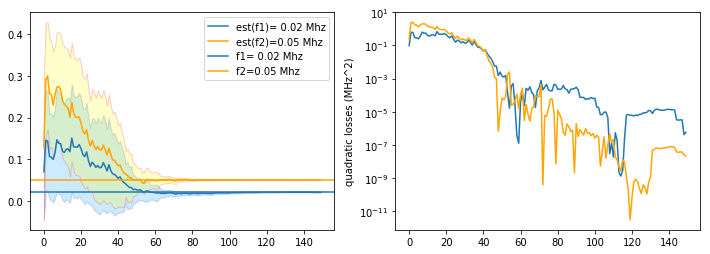

No handles with labels found to put in legend.
No handles with labels found to put in legend.


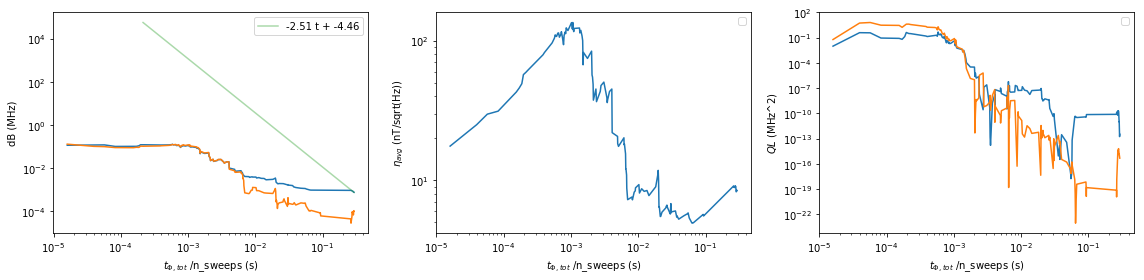

DEBUG: len z_err 0, z_corr 150


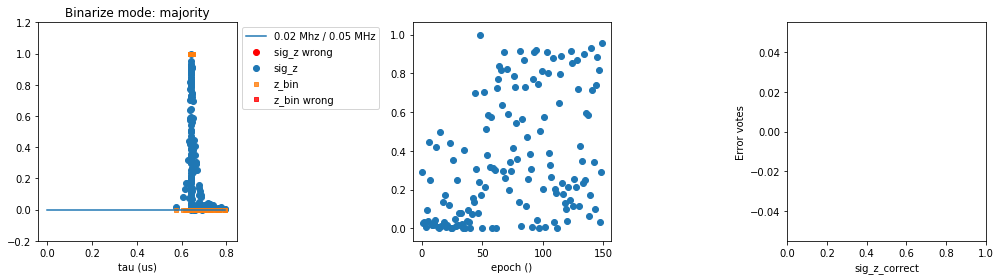

No handles with labels found to put in legend.


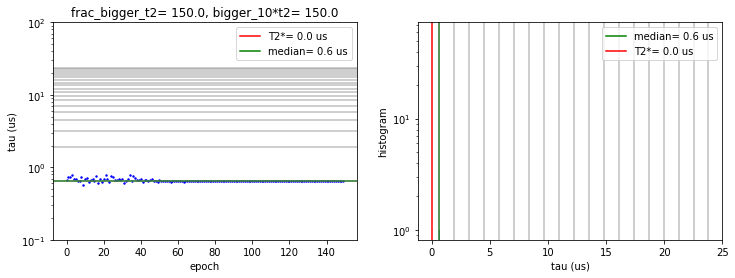

Searching for best FI around tau= 0.6436994322868972 us, A_par= 0.12566370614359174 (prior A_par: 0.1008629027394844 - 0.1461237799898864)


C:\Users\Timo\OneDrive\_Promotion\Software\MFL_repo\mfl_sensing_simplelib.py:3856: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(p1*(1-p1))*d_p1_par**2, 1/(p1*(1-p1))*d_p1_perp**2, w1, w2
C:\Users\Timo\OneDrive\_Promotion\Software\MFL_repo\mfl_sensing_simplelib.py:3856: RuntimeWarning: invalid value encountered in multiply
  return 1/(p1*(1-p1))*d_p1_par**2, 1/(p1*(1-p1))*d_p1_perp**2, w1, w2


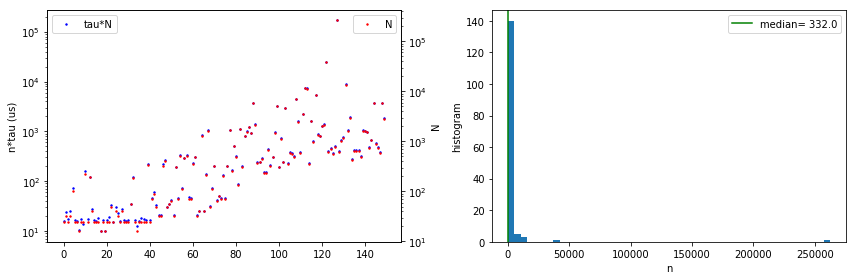

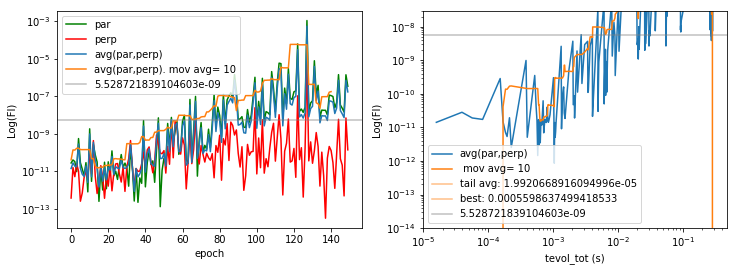

Best FI (par, perp, sum) @ tau= 0.6487245579150379/ 0.6587748091713194/ 0.6487245579150379 us, n_dd= 510/ 494/ 510


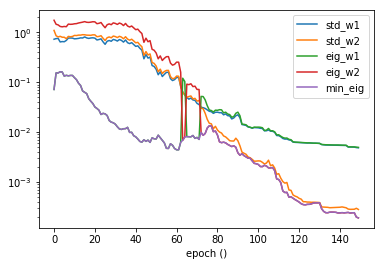

No handles with labels found to put in legend.


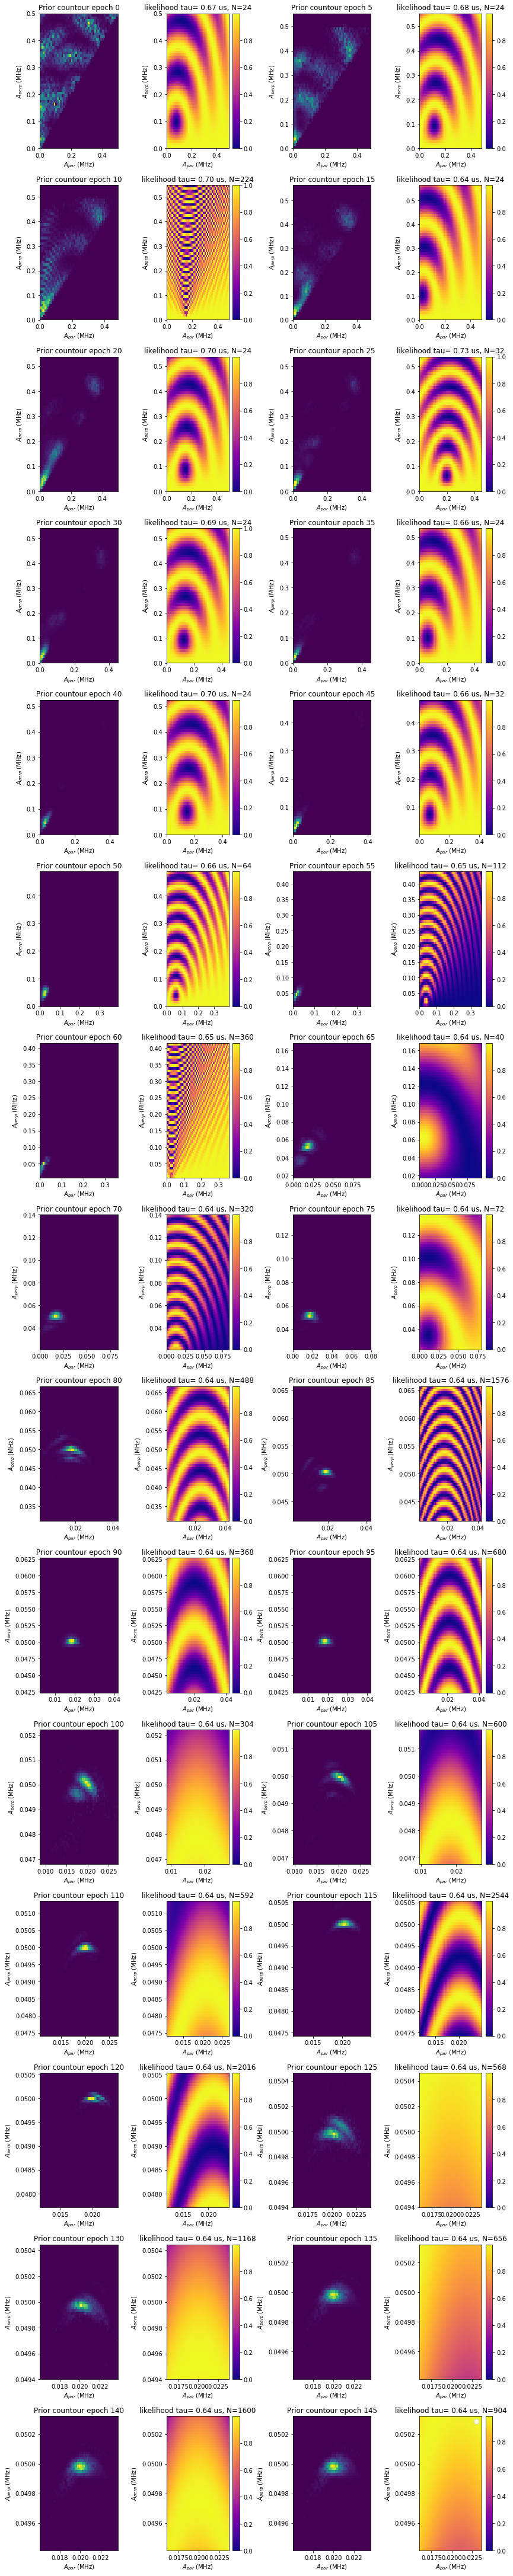

In [135]:
# run MFL
set_common_params()
hahn_b_gauss = 735

t2star_s = 0 #10e-6
t2a_s = 0#0e-6
t2b_s = 0#500e-6

n_epochs = 150#400
n_pi_dd_max = 4000 #8096

binarize_mode =  'majority' #'rand_coin' #
noise_n_rep = 1000
noise_mode = None

exp_mode = 'dd'
gamma_n = 1.0705e3 * 2*np.pi # 13-C
a_lamor = gamma_n*hahn_b_gauss/(2*np.pi*1e6)
ndd_mod = 8

"""
freq_max = 2*np.pi*a_lamor # MHz rad, MUST BE < LAMOR
freq_min = 0
freq_min_1 = 2*np.pi*0.5

true_omega_1 = -2*np.pi*0.7  #0.6
true_omega_2 = 2*np.pi*0.1   #np.pi/2
true_params = np.array([[true_omega_1, true_omega_2]])
"""

#freq_max = 2*np.pi*0.2 # mhz rad
print(get_params())

reset_result()
run_estimation(n_epochs=n_epochs, n_sweeps=1)



save_folder = "C:/Users/Timo/Desktop/multiMFL_results"
save_folder = save_folder + '.' + str(get_file_index(save_folder))
#enable_safe(save_folder)
#save_notebook(dir())
plot_result()
plot_scaling()
#plot_clusters()
plot_zs()
errors = get_error_zs()


#print("rel error= {:.2f}%. rel uncer= {:.2f}%. Error datums: {} ({:.1f} %)".format(
#    100*(track_eval[-1]-true_omega)/true_omega, 100*(track_cov[-1][0][0]/track_eval[-1]),
#    len(errs), len(errs)/n_epochs*100))
#print("in (epoch, val, val_noNoise): {}".format(errs))

#plot_noise_model(n_samples=1e4, n_bins=15)

taus_res = est_tau_res(true_omega_1/(2*np.pi), hahn_b_gauss, np.asarray(range(1, 20, 1)))
plot_taus(hlines=taus_res)
plot_taus_ns()

fi_opt, tau_opt, n_opt = calc_best_fisher(np.median(np.asarray(track_tau).flatten()*1e-9))
plot_fisher(hlines=[fi_opt[2]])
print("Best FI (par, perp, sum) @ tau= {}/ {}/ {} us, n_dd= {}/ {}/ {}".format(tau_opt[0]*1e6, tau_opt[1]*1e6, tau_opt[2]*1e6,
                                                                               n_opt[0], n_opt[1], n_opt[2]))
 
plot_sig_p()


# covariance 2d
plot_priors_2d_gaussian_heatmap(epochs_idx=range(0, n_epochs, 5), n_bins=50, plot_likelihoods=True)
#plot_priors(epochs_idx=range(0, n_epochs, 1), n_bins=50, always_show_err=True)
#plot_priors(epochs_idx=range(0, n_epochs//10, 1), n_bins=20)



In [ ]:
len(track_tau)

# Likelihoods for Hahn / DD 

In [45]:
# Zhao2012 (19)

def calc_sig_z_hahn(tau, phi_h01= np.pi/4.):
    # phi_h01: angle between B_ext and effective field B-A_j^(1)
    # single nucleus
    gamma = 2.8e6 * 2*np.pi
    B = 100   # Gauss 
    A = 10e6 * 2*np.pi   # Mhz rad (absolute value of hyperfine field vector)

    h_0 = B
    # attention: valid only if A_perp << A_paral
    h_1 = B - A/gamma
    h_1 = B - A/gamma
    t_evol = 2*tau
    theta_0 = gamma* h_0 * t_evol
    theta_1 = gamma* h_1 * t_evol
 
    l_hahn = 1 - 2* np.sin(phi_h01)**2 *np.sin(theta_0/2)**2 * np.sin(theta_1/2)**2
    
    return l_hahn


def calc_dd_angles(A_abs, tau, n_dd, alpha=np.pi/4, B=150):

    gamma = 1.0705e3 * 2*np.pi # 13-C
    
    A = A_abs    # Hz rad (absolute value of hyperfine field vector)
    A_par = A * np.cos(alpha)
    A_perp = A * np.sin(alpha)
    A_as_B = A / gamma  # Hz rad --> Gauss
     
    h_0 = B
    # assumes NV || B => B=0 along A_perp
    h_1 = np.sqrt((B - A_par / gamma)** 2 + (A_perp / gamma)** 2)
    t_evol = tau/2
    theta_0 = gamma* h_0 * t_evol
    theta_1 = gamma* h_1 * t_evol
    
    phi_h01 = np.arcsin(A_as_B * np.sin(alpha) / (np.sqrt(B ** 2 - 2 * A_as_B * B * np.cos(alpha) + A_as_B ** 2)))
    alpha_20 = np.arctan( (np.sin(theta_0/2) * np.sin(theta_1/2) * np.sin(phi_h01))/
                       (np.cos(theta_0/2) * np.cos(theta_1/2) - np.sin(theta_0/2)*np.sin(theta_1/2)*np.cos(phi_h01))
                      )
    theta_20 = 2*np.arccos(np.cos(theta_0)*np.cos(theta_1) - np.sin(theta_0)*np.sin(theta_1)*np.cos(phi_h01)
                        )
    
    # alpha and theta according Zhao 2012 eqn (20)
    return phi_h01, alpha_20, theta_20

def likelihood_dd(A_abs, tau, n_dd, alpha=np.pi/4, B=150, only_lamor_part=False):

    # B: Gauss
    #gamma = 2.8e6 * 2*np.pi  # NV
    gamma = 1.0705e3 * 2*np.pi # 13-C
    
    A = A_abs    # Hz rad (absolute value of hyperfine field vector)
    A_par = A * np.cos(alpha)
    A_perp = A * np.sin(alpha)
    A_as_B = A / gamma  # Hz rad --> Gauss
     
    h_0 = B
    # assumes NV || B => B=0 along A_perp
    h_1 = np.sqrt((B - A_par / gamma)** 2 + (A_perp / gamma)** 2)
    t_evol = tau/2
    theta_0 = gamma* h_0 * t_evol
    theta_1 = gamma* h_1 * t_evol
    if only_lamor_part:
        theta_1 = theta_0
    

    phi_h01 = np.arcsin(A_as_B * np.sin(alpha) / (np.sqrt(B ** 2 - 2 * A_as_B * B * np.cos(alpha) + A_as_B ** 2)))

    # gamma in Hz rad / G (w units)
    theta_0 = gamma * h_0 * t_evol 
    theta_1 = gamma * h_1 * t_evol 
    alpha_20 = np.arctan( (np.sin(theta_0/2) * np.sin(theta_1/2) * np.sin(phi_h01))/
                       (np.cos(theta_0/2) * np.cos(theta_1/2) - np.sin(theta_0/2)*np.sin(theta_1/2)*np.cos(phi_h01))
                      )
    theta = 2*np.arccos(np.cos(theta_0)*np.cos(theta_1) - np.sin(theta_0)*np.sin(theta_1)*np.cos(phi_h01)
                        )

    #print("DEBUG: alpha: {} theta_0 {}".format(alpha_20, theta_0))
    l_hahn = 1 - 2* np.sin(phi_h01)**2 *np.sin(theta_0/2)**2 * np.sin(theta_1/2)**2
    # todo: n_dd%2!=0 case is buggy! (still?)
    l_dd = 1 - 2 * np.sin(alpha_20)** 2 * np.sin(n_dd * theta / 4) ** 2
    l_corr = 0  # this is an approximation!

    l_dd = (n_dd%2)*(l_hahn*l_dd + l_corr) + (((n_dd+1)%2))*l_dd
    
    l = 0.5 + 0.5 * l_dd
    
    return l

def likelihood_dd_taminiau(A_abs, tau, n_dd, alpha=np.pi/4, B=150):
   
    A = A_abs    # Hz rad (absolute value of hyperfine field vector)
    A_par = A * np.cos(alpha)
    A_perp = A * np.sin(alpha)
        
    phi = phi_in_nsweep(tau, A_par/(2*np.pi*1e6), A_perp/(2*np.pi*1e6), B_gauss)
    ampl = ampl_in_sweep(tau, A_par/(2*np.pi*1e6), A_perp/(2*np.pi*1e6), B_gauss)
    #print(phi.shape)
    return (1-ampl*np.sin(n_dd*phi/2)**2)


alpha = 0.1 #np.arccos(0.5e6 / 1e6)
print("{} / {} rad/pi".format(alpha, alpha/np.pi))
likelihood_dd(2*np.pi*96.479e3, 31.28e-6, 3, alpha=alpha, B=75)
calc_dd_angles(2*np.pi*96.479e3, 31.28e-6, 3, alpha=alpha, B=75)

0.1 / 0.03183098861837907 rad/pi


(0.5500114573867672, -1.3903712004698532, 5.061069470965523)

## Likelihood with Alpha=const, n=const 

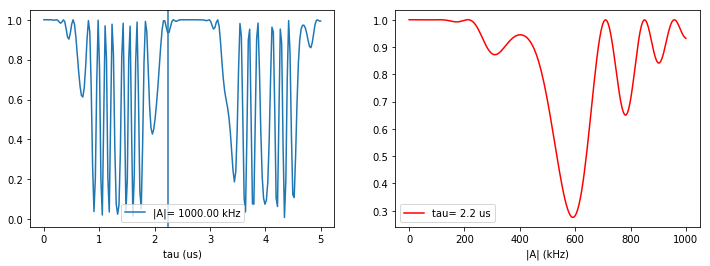

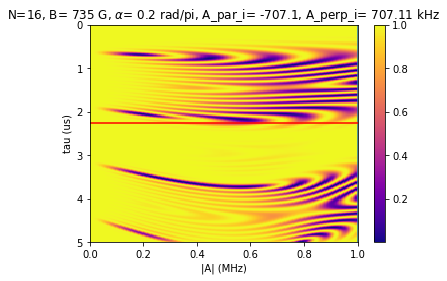

In [421]:
def plot_l_alpha_const():
    tau = np.linspace(0, 5e-6, 200)
    m_A = np.linspace(0,2*np.pi*1e6, 200)  # MHz rad
    n_dd = 16
        
    alpha = np.pi/4
    
    m_A_i = 2*np.pi*1000.00e3  # Hz rad
    m_a_perp_i = np.sin(alpha)*m_A_i
    m_a_par_i = -np.cos(alpha)*m_A_i
    tau_i = 2.25e-6
    B = 735   # 300

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(tau*1e6, likelihood_dd(m_A_i, tau, n_dd, B=B, alpha=alpha), label="|A|= {:.2f} kHz".format(m_A_i/(2*np.pi*1e3)))
    plt.axvline(tau_i*1e6)
    plt.xlabel("tau (us)")
    plt.legend()


    res = np.zeros((len(tau), len(m_A)))
    for i, A in enumerate(m_A):
        for j, t in enumerate(tau):
            res[j, i] = likelihood_dd(A, t, n_dd, B=B, alpha=alpha)


    plt.subplot(122)
    plt.plot(m_A/(1e3*2*np.pi), likelihood_dd(m_A, tau_i,n_dd, B=B, alpha=alpha), label="tau= {:.1f} us".format(tau_i*1e6), color='red')
    plt.xlabel("|A| (kHz)")
    plt.legend()
    plt.show()
    
    #plt.imshow(res, vmin=0, extent=[m_A[0]/1e6, m_A[-1]/1e6, tau[-1]*1e6, tau[0]*1e6],
    #           cmap='plasma', aspect='auto')
    plt.imshow(res, extent=[m_A[0]/(2*np.pi*1e6), m_A[-1]/(2*np.pi*1e6), tau[-1]*1e6, tau[0]*1e6],
               cmap='plasma', aspect='auto')
    plt.axvline(m_A_i/(2*np.pi*1e6))
    plt.axhline(tau_i*1e6, color='red')
    plt.xlabel("|A| (MHz)")
    plt.ylabel("tau (us)")
    plt.title(r'N={}, B= {:d} G, $\alpha$= {:.1f} rad/pi, A_par_i= {:.1f}, A_perp_i= {:.2f} kHz'.format(
        n_dd, B, alpha/np.pi, m_a_par_i/(2*np.pi*1e3), m_a_perp_i/(2*np.pi*1e3)))
    plt.colorbar()
    
plot_l_alpha_const()

## A_par, n = const

No handles with labels found to put in legend.
No handles with labels found to put in legend.


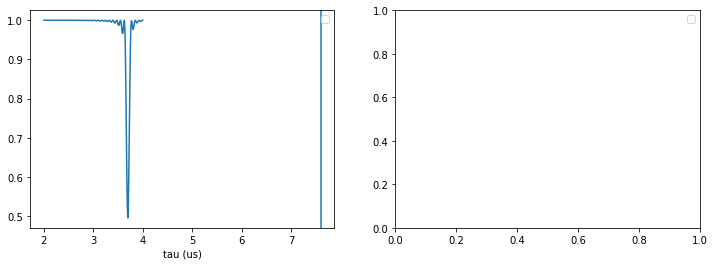

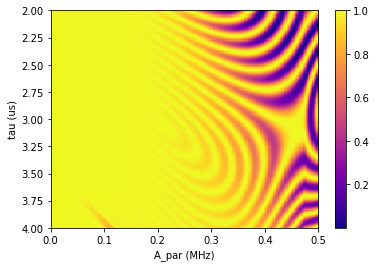

In [249]:
def plot_l_a_perp_const(a_perp_mhz=1e6):
    tau = np.linspace(2e-6, 4e-6, 200)
    m_A_par = np.linspace(0,2*np.pi*0.5e6, 200)  # MHz rad
    n_dd = 32 # 32
    
    m_A_i = 2*np.pi*50.00e3  # Hz rad
    
    A_tot = np.sqrt((2*np.pi*a_perp_mhz)**2 + m_A_par**2)  # Mhz rad    
    alpha = np.arccos(2*np.pi*a_perp_mhz/A_tot)
    
    m_a_perp_i = np.sin(alpha)*m_A_i
    m_a_par_i = m_A_i
    tau_i = 7.6e-6
    B = 400   # 300

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(tau*1e6, likelihood_dd(m_A_i, tau, n_dd, B=B, alpha=alpha))#, label="|A|= {:.2f} kHz".format(m_A_i/(2*np.pi*1e3)))
    plt.axvline(tau_i*1e6)
    plt.xlabel("tau (us)")
    plt.legend()


    res = np.zeros((len(tau), len(m_A_par)))
    for i, A in enumerate(m_A_par):
        for j, t in enumerate(tau):
            A_tot_i = np.sqrt((2*np.pi*a_perp_mhz)**2 + A**2)  # Mhz rad    
            alpha_i = np.arccos(2*np.pi*a_perp_mhz/A_tot_i)
            res[j, i] = likelihood_dd(A, t, n_dd, B=B, alpha=alpha_i)

    
    plt.subplot(122)
    #plt.plot(m_A/(1e3*2*np.pi), likelihood_dd(m_A, tau_i,n_dd, B=B, alpha=alpha), label="tau= {:.1f} us".format(tau_i*1e6), color='red')
    #plt.xlabel("|A| (kHz)")
    plt.legend()
    plt.show()
    
    #plt.imshow(res, vmin=0, extent=[m_A[0]/1e6, m_A[-1]/1e6, tau[-1]*1e6, tau[0]*1e6],
    #           cmap='plasma', aspect='auto')
    plt.imshow(res, extent=[m_A_par[0]/(2*np.pi*1e6), m_A_par[-1]/(2*np.pi*1e6), tau[-1]*1e6, tau[0]*1e6],
               cmap='plasma', aspect='auto')
    #plt.axvline(m_A_i/(2*np.pi*1e6))
    #plt.axhline(tau_i*1e6, color='red')
    plt.xlabel("A_par (MHz)")
    plt.ylabel("tau (us)")
    #plt.title(r'N={}, B= {:d} G, $\alpha$= {:.1f} rad/pi, A_par_i= {:.1f}, A_perp_i= {:.2f} kHz'.format(
    #    n_dd, B, alpha/np.pi, m_a_par_i/(2*np.pi*1e3), m_a_perp_i/(2*np.pi*1e3)))
    plt.colorbar()
    
plot_l_a_perp_const()

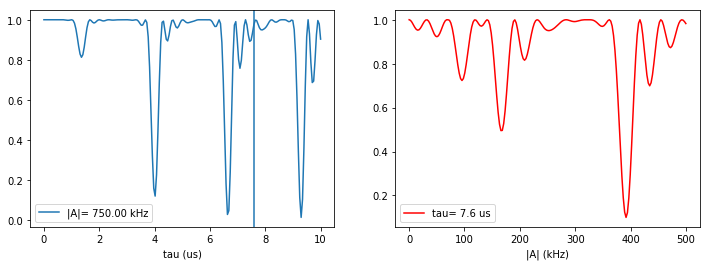

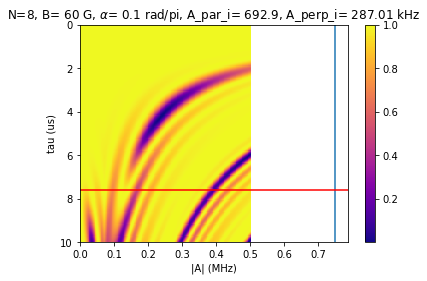

In [1030]:
def plot_l_alpha_const():
    tau = np.linspace(0e-6, 10e-6, 200)
    m_A = np.linspace(0,2*np.pi*0.5e6, 200)  # MHz rad
    n_dd = 8 # 32
        
    alpha = np.pi/8
    m_A_i = 2*np.pi*750.00e3  # Hz rad
    m_a_perp_i = np.sin(alpha)*m_A_i
    m_a_par_i = np.cos(alpha)*m_A_i
    tau_i = 7.6e-6
    B = 60   # 300

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(tau*1e6, likelihood_dd(m_A_i, tau, n_dd, B=B, alpha=alpha), label="|A|= {:.2f} kHz".format(m_A_i/(2*np.pi*1e3)))
    plt.axvline(tau_i*1e6)
    plt.xlabel("tau (us)")
    plt.legend()


    res = np.zeros((len(tau), len(m_A)))
    for i, A in enumerate(m_A):
        for j, t in enumerate(tau):
            res[j, i] = likelihood_dd(A, t, n_dd, B=B, alpha=alpha)


    plt.subplot(122)
    plt.plot(m_A/(1e3*2*np.pi), likelihood_dd(m_A, tau_i,n_dd, B=B, alpha=alpha), label="tau= {:.1f} us".format(tau_i*1e6), color='red')
    plt.xlabel("|A| (kHz)")
    plt.legend()
    plt.show()
    
    #plt.imshow(res, vmin=0, extent=[m_A[0]/1e6, m_A[-1]/1e6, tau[-1]*1e6, tau[0]*1e6],
    #           cmap='plasma', aspect='auto')
    plt.imshow(res, extent=[m_A[0]/(2*np.pi*1e6), m_A[-1]/(2*np.pi*1e6), tau[-1]*1e6, tau[0]*1e6],
               cmap='plasma', aspect='auto')
    plt.axvline(m_A_i/(2*np.pi*1e6))
    plt.axhline(tau_i*1e6, color='red')
    plt.xlabel("|A| (MHz)")
    plt.ylabel("tau (us)")
    plt.title(r'N={}, B= {:d} G, $\alpha$= {:.1f} rad/pi, A_par_i= {:.1f}, A_perp_i= {:.2f} kHz'.format(
        n_dd, B, alpha/np.pi, m_a_par_i/(2*np.pi*1e3), m_a_perp_i/(2*np.pi*1e3)))
    plt.colorbar()
    
plot_l_alpha_const()

## On resoance, as function of N

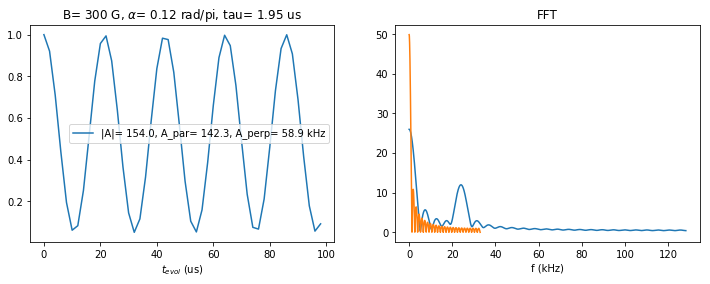

In [323]:
# for 120 kHz coupled
tau_i = 1.95e-6#6.95e-6 #5.5055e-6
m_A_i = 2*np.pi*154e3  # 240 # Hz rad
m_a_par_i = np.cos(alpha)*m_A_i
m_a_perp_i = np.sin(alpha)*m_A_i
alpha = np.pi/8
B = 300
# for 240 kHz coupled
tau_i_2 = 7.6e-6 #5.5055e-6
m_A_i_2 = 2*np.pi*120e3  # Hz rad
m_a_par_i = np.cos(alpha)*m_A_i
m_a_perp_i = np.sin(alpha)*m_A_i


#ns = np.linspace(1,16,16)  # odd n code is still buggy!
ns = np.arange(0,100,2)


plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(r'B= {:d} G, $\alpha$= {:.2f} rad/pi, tau= {} us'.format(
         B, alpha/np.pi, tau_i*1e6))
res = np.zeros(len(ns))
time = np.zeros(len(ns))
res_2 = np.zeros(len(ns))
time_2 = np.zeros(len(ns))

for i, n in enumerate(ns): 
    res[i] = likelihood_dd(m_A_i, tau_i, n, B=B, alpha=alpha)
    time[i] = (n)*tau_i
for i, n in enumerate(ns): 
    res_2[i] = likelihood_dd(m_A_i_2, tau_i_2, n, B=B, alpha=alpha)
    time_2[i] = (n)*tau_i_2
    
plt.plot(ns, res, label="|A|= {:.1f}, A_par= {:.1f}, A_perp= {:.1f} kHz".format(m_A_i/(2*np.pi*1e3),m_a_par_i/(2*np.pi*1e3),m_a_perp_i/(2*np.pi*1e3)))

#plt.plot(ns, res_2, label="|A|= {:.1f} kHz".format(m_A_i_2/(2*np.pi*1e3)))
plt.xlabel(r"$t_{evol}$ (us)")
plt.legend()

plt.subplot(122)
plt.title(r'FFT'.format(
         B, alpha/np.pi, m_a_par_i/(2*np.pi*1e6), m_a_perp_i/(2*np.pi*1e6)))
n_zero_padding = 4096
fft_val = abs(np.fft.rfft(res, n=n_zero_padding))
freq = np.fft.rfftfreq(n_zero_padding, time[2]-time[1])
fft_val_2 = abs(np.fft.rfft(res_2, n=n_zero_padding))
freq_2 = np.fft.rfftfreq(n_zero_padding, time_2[2]-time_2[1])

plt.plot(freq/1e3, fft_val)
plt.plot(freq_2/1e3, fft_val_2)
plt.xlabel("f (kHz)")
plt.show()

## Likelihood with exp (N, tau) = const 

C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10


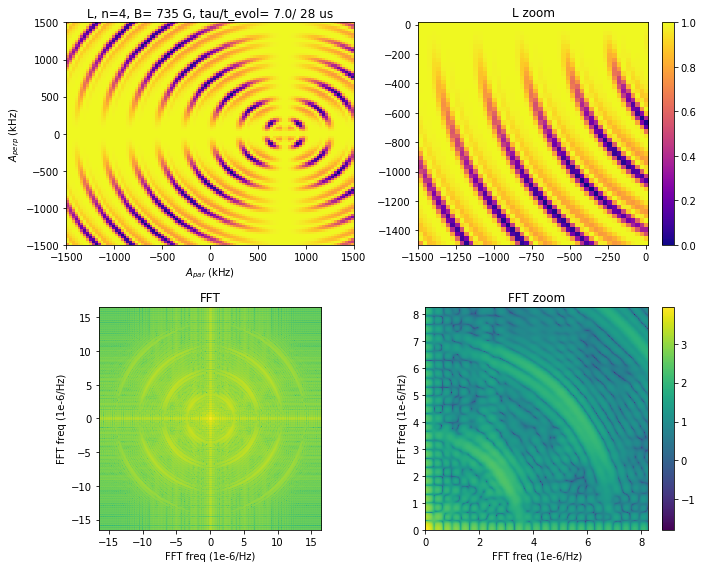

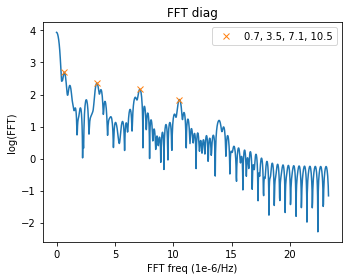

In [407]:
from scipy.signal import find_peaks

def plot_l_tau_const():
    
    n_dd = 4
            
    m_A_par =  np.linspace(-2*np.pi*1500e3, 2*np.pi*1500e3, 100)  # MHz rad
    m_A_perp = np.linspace(-2*np.pi*1500e3 ,2*np.pi*1500e3, 100)

    tau_i = 7*1e-6
    B = 735

   
    res = np.zeros((len(m_A_perp), len(m_A_par)))
    for i, a_par in enumerate(m_A_par):
        for j, a_perp in enumerate(m_A_perp):
            m_A_i = np.sqrt(a_par**2+a_perp**2)
            alpha = np.arccos(a_par/m_A_i)
            
            res[j, i] = likelihood_dd(m_A_i, tau_i, n_dd, B=B, alpha=alpha)

            
    plt.figure(figsize=(10,8))
    plt.subplot(221)
    plt.title('L, n={}, B= {:d} G, tau/t_evol= {:.1f}/ {:.0f} us'.format(n_dd, B, tau_i*1e6, tau_i*1e6*n_dd))
    plt.xlabel(r"$A_{par}$ (kHz)")
    plt.ylabel(r"$A_{perp}$ (kHz)")
    plt.imshow(res, vmin=0, extent=[m_A_par[0]/(2*np.pi*1e3), m_A_par[-1]/(2*np.pi*1e3),
                                    m_A_perp[0]/(2*np.pi*1e3), m_A_perp[-1]/(2*np.pi*1e3)],
           cmap='plasma', aspect='auto', origin='lower')
    plt.subplot(222)   
    plt.title('L zoom')
    plt.imshow(res[0:50,0:50], vmin=0, extent=[m_A_par[0]/(2*np.pi*1e3), m_A_par[50]/(2*np.pi*1e3),
                                    m_A_perp[0]/(2*np.pi*1e3), m_A_perp[50]/(2*np.pi*1e3)],
           cmap='plasma', aspect='auto', origin='lower')
    #plt.axvline(alpha_i/(np.pi))
    #plt.axhline(m_A_i/1e6, color='red')
    plt.colorbar()
    
    # FFT
    n_zero_pad = 2048
    fs_2d = np.fft.fft2(res, s=[n_zero_pad, n_zero_pad])
    fs_2d = np.fft.fftshift(fs_2d)
    fft_freq_x = np.fft.fftfreq(n=n_zero_pad, d=(m_A_par[1]-m_A_par[0])/(2*np.pi))
    fft_freq_y = np.fft.fftfreq(n=n_zero_pad, d=(m_A_perp[1]-m_A_perp[0])/(2*np.pi))
    fft_freq_x = np.fft.fftshift(fft_freq_x)
    fft_freq_y = np.fft.fftshift(fft_freq_y)
    
    #req_x  = np.fft.fftfreq(fs_2d.shape[0], d=8 / (N - 1))
    
    plt.subplot(223)
    plt.imshow(np.log10(abs(fs_2d)), origin='lower',
              extent=[1e6*fft_freq_x[0], 1e6*fft_freq_x[-1],
                      1e6*fft_freq_y[0], 1e6*fft_freq_y[-1]])
    #print(res)
    plt.xlabel(r"FFT freq (1e-6/Hz)")
    plt.ylabel(r"FFT freq (1e-6/Hz)")
    plt.title('FFT')


    plt.subplot(224)
    n_x = n_zero_pad
    n_y = n_zero_pad
  
    plt.imshow(np.log10(abs(fs_2d[int(n_x/2):int(n_x/2+n_x/4),
                                  int(n_y/2):int(n_y/2+n_y/4)])),
               extent=[1e6*fft_freq_x[int(n_x/2)], 1e6*fft_freq_x[int(n_x/2+n_x/4)],
                      1e6*fft_freq_y[int(n_y/2)], 1e6*fft_freq_y[int(n_y/2+n_y/4)]],
               origin='lower')
    plt.colorbar()
    plt.xlabel(r"FFT freq (1e-6/Hz)")
    plt.ylabel(r"FFT freq (1e-6/Hz)")
    #print(res)
  
    plt.title('FFT zoom')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(5,4))
    plt.title('FFT diag')
    fft_freq_diag = np.sqrt(fft_freq_x**2+fft_freq_y**2)[int(n_x/2):]
    df = fft_freq_diag[1]-fft_freq_diag[0]
    fft = np.log10(abs(np.diag(fs_2d[int(n_x/2):, int(n_y/2):])))
    
    distance_f = 2e-6
    n_peaks = 4
    peaks, _ = find_peaks(fft, distance=distance_f/df, threshold=0)
    peaks_zip = zip(peaks, fft[peaks])
    peaks_ordered = sorted(peaks_zip, key=lambda x: abs(x[1]))
    peaks_dominant = np.asarray(list(sorted(np.asarray([tuple[0] for tuple in peaks_ordered[-n_peaks:]], dtype=int))))
    #print(peaks_ordered)
    #print([tuple[0] for tuple in peaks_ordered[-3:]])
    #print(peaks_dominant*df*1e6)
    
    #plt.plot(fft)
    plt.plot(1e6*fft_freq_diag, fft)
    plt.plot(1e6*peaks_dominant*df, fft[peaks_dominant], "x", label="{:.1f}, {:.1f}, {:.1f}, {:.1f}".format(
            1e6*peaks_dominant[0]*df,1e6*peaks_dominant[1]*df,1e6*peaks_dominant[2]*df,1e6*peaks_dominant[3]*df))
    plt.ylabel(r"log(FFT)")
    plt.xlabel(r"FFT freq (1e-6/Hz)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_l_tau_const()


## Alpha and theta (Zhao eqn 20) angles

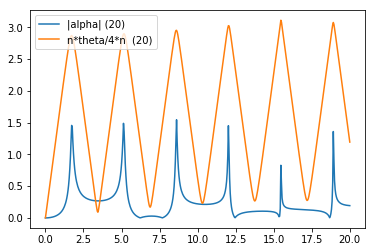

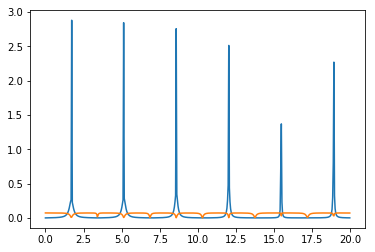

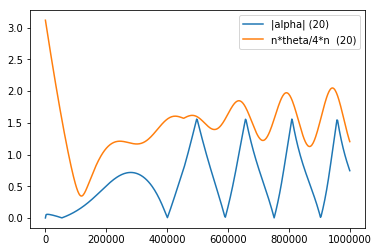

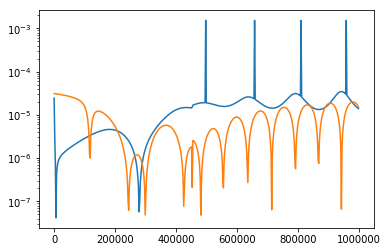

In [326]:
# tau domain
B = 300 # Gauss
alpha_A = np.pi/4
A = 2*np.pi*100e3
n = 2

tau = np.linspace(0,20e-6,500)

_, alpha, theta = calc_dd_angles(2*np.pi*100e3, tau, n, alpha=alpha_A, B=B)

plt.plot(tau*1e6, abs(alpha), label="|alpha| (20)")
plt.plot(tau*1e6, abs(n*theta / 4), label="n*theta/4*n  (20)")
plt.legend()
plt.show()

plt.plot(tau[0:-1]*1e6, abs(np.diff(alpha)))
plt.plot(tau[0:-1]*1e6, abs(np.diff(n*theta / 4)))
plt.show()

# A domain
A = np.linspace(0,2*np.pi*1e6,500)
tau = 14e-6

_, alpha, theta = calc_dd_angles(A, tau, n, alpha=alpha_A, B=B)

plt.plot(A/(2*np.pi), abs(alpha), label="|alpha| (20)")
plt.plot(A/(2*np.pi), abs(n*theta / 4), label="n*theta/4*n  (20)")
plt.legend()
plt.show()

plt.semilogy(A[0:-1]/(2*np.pi), abs(np.diff(alpha))/(np.diff(A/(2*np.pi))))
plt.semilogy(A[0:-1]/(2*np.pi), abs(np.diff(n*theta / 4))/(np.diff(A/(2*np.pi))))
#plt.plot(A[0:-1]*1e-6/(2*np.pi), abs(np.diff(n*theta / 4)+abs(np.diff(alpha))))
#plt.plot(A[0:-1]*1e-6/(2*np.pi), abs(abs(np.diff(n*theta / 4)-abs(np.diff(alpha)))))


# Likelihoods directly from model

## Resonance

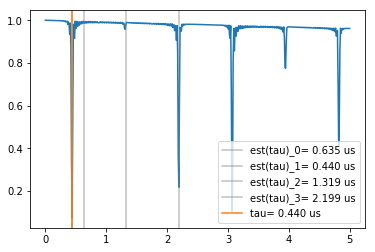

Text(0.5, 0, 't_evol (us)')

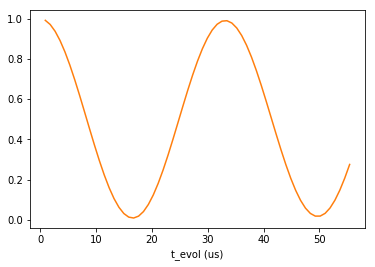

In [85]:
tau = np.linspace(0,5e-6,500)
A_par_mhz, A_perp_mhz = -700e-3, 140e-3#54e-3 #50e-3, 21e-3 
t2_a, t2_b = 1000e-6,1000e-6
B = 735

p1 = get_p_vs_t(tau, A_par_mhz, A_perp_mhz, n_dd=32, t2_a=t2_a, t2_b=t2_b, b_gauss=B)
k_res = np.arange(0, 4,1)

heuristic_t = MultiDD_EstAOptFish_PGH(None, B, inv_field=['w1','w2'], n_pi_max=256,
                                            opt_mode='fi_trace', restr_ndd_mod=2)
tau_res_est = heuristic_t.calc_tau_k(1*A_par_mhz, k_res, no_warning=True, b_gauss=B)
tau_res = tau_res_est[1]
#tau_res = 2.20e-6

plt.plot(tau*1e6, p1)
for i, t in enumerate(tau_res_est):
    if t < np.max(tau):
        plt.axvline(t*1e6, label="est(tau)_{}= {:.3f} us".format(k_res[i], t*1e6), color='grey', alpha=0.5)
plt.axvline(tau_res*1e6, label="tau= {:.3f} us".format(tau_res*1e6), color='C1')
plt.legend()
plt.show()

n_dd = np.arange(2, 128, 2)
t_evol = tau_res* n_dd

p1 = get_p_vs_n(n_dd, A_par_mhz, A_perp_mhz, tau=tau_res, t2_a=t2_a, t2_b=t2_b, b_gauss=B)

plt.plot(t_evol*1e6, p1, color='C1')
plt.xlabel("t_evol (us)")

## Resonance 2D (tau, n)

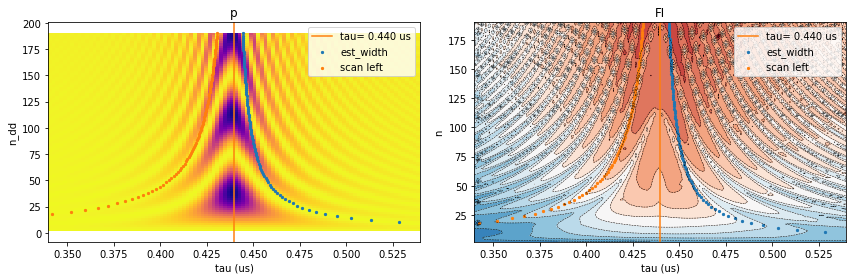

In [86]:
tau = np.linspace(tau_res-0.1e-6,tau_res+0.1e-6,100)
n_dd = np.arange(2, 192, 2)
t2_a, t2_b = 1000e-6,1000e-6

prior_t = qi.UniformDistribution(np.asarray([[2*np.pi*A_par_mhz, 2*np.pi*A_par_mhz+0.01],[2*np.pi*A_perp_mhz, 2*np.pi*A_perp_mhz+0.01]])) # negative A_par
model_t = MultimodeDDModel(b_gauss=B, min_freq=0) 
updater_t = basic_SMCUpdater(model_t, n_particles, prior_t, resample_a=mfl_res_a, resample_thresh=mfl_res_th)
heuristic_t = MultiDD_EstAnResOptFish_PGH(updater_t, B)
heuristic_t._cheat_w_true = [2*np.pi*A_par_mhz, 2*np.pi*A_par_mhz]

sigma_tau = heuristic_t.estimate_tau_res_width(tau_res, n_dd)
scan_range_l, scan_range_r = heuristic_t.estimate_tau_range(tau_res, n_dd)

# Probability
p_list = []
for n in n_dd:
    p_list.append(get_p_vs_t(tau, A_par_mhz, A_perp_mhz, n_dd=n, t2_a=t2_a, t2_b=t2_b, b_gauss=B))

p = np.asarray(p_list)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(p, extent=[1e6*tau[0], 1e6*tau[-1],
                                                 n_dd[0], n_dd[-1]],
                           cmap='plasma', aspect='auto', origin='lower')

plt.axvline(tau_res*1e6, label="tau= {:.3f} us".format(tau_res*1e6), color='C1')
plt.scatter(1e6*(tau_res + sigma_tau), n_dd, s=5, label="est_width")
plt.scatter(1e6*(scan_range_l), n_dd, s=5, label="scan left")

plt.xlabel("tau (us)")
plt.ylabel("n_dd")
plt.xlim([np.min(tau)*1e6,np.max(tau)*1e6])
plt.title("p")
plt.legend()

# Fisher information
Apar, Aperp = 2*np.pi*A_par_mhz, 2*np.pi*A_perp_mhz
fi = np.zeros((len(tau), len(n_dd)))

tau_us_grid, n_dd_grid = np.meshgrid(tau*1e6, n_dd)

fi_list = heuristic_t.calc_fisher_information_at_A(Apar/(2*np.pi), Aperp/(2*np.pi), tau_us=tau_us_grid.flatten(), n_dd=n_dd_grid.flatten())
fi_par_vs_n = np.asarray([el[0] for el in fi_list])
fi_par_vs_n[np.isnan(fi_par_vs_n)] = -np.inf
fi_par_vs_n[np.isinf(fi_par_vs_n)] = -np.inf

fi_perp_vs_n =  np.asarray([el[1] for el in fi_list])
fi_perp_vs_n[np.isnan(fi_perp_vs_n)] = -np.inf
fi_perp_vs_n[np.isinf(fi_perp_vs_n)] = -np.inf

x = tau_us_grid.flatten()
y = n_dd_grid.flatten()
z = np.log(fi_par_vs_n + fi_perp_vs_n)

"""
z = z.reshape(len(n_dd), len(tau))
plt.subplot(122)
plt.imshow(z, extent=[1e6*tau[0], 1e6*tau[-1],
                                                 n_dd[0], n_dd[-1]],
                           cmap="RdBu_r", aspect='auto', origin='lower')

"""
#"""
import matplotlib.pyplot as plt
import matplotlib.tri as tri
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
xi = np.linspace(np.min(x), np.max(x), 100)
yi = np.linspace(np.min(y), np.max(y), 100)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

plt.subplot(122)
ax1 = plt.gca()
ax1.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")

plt.axvline(tau_res*1e6, label="tau= {:.3f} us".format(tau_res*1e6), color='C1')
plt.scatter(1e6*(tau_res + sigma_tau), n_dd, s=5, label="est_width")
plt.scatter(1e6*(scan_range_l), n_dd, s=5, label="scan left")
ax1.plot(x, y, 'ko', ms=0)
ax1.set(xlim=(np.min(x), np.max(x)), ylim=(np.min(y), np.max(y)))

plt.xlabel("tau (us)")
plt.legend()
plt.ylabel("n")
plt.title("FI")
#"""

plt.tight_layout()
plt.show()

## Resonance Linewidth

Text(0, 0.5, '$\\sigma \\tau$ (ns)')

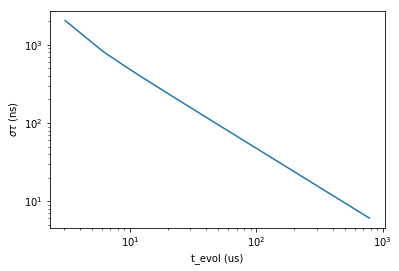

In [80]:
A_par, A_perp = 45.7e-3, 21e-3
tau_res = heuristic.calc_tau_k(A_par/(2*np.pi), 1, no_warning=True)

n_dd = np.arange(2, 512, 2)
t_evol = tau_res* n_dd

sigma_tau = heuristic.estimate_tau_res_width(tau_res, n_dd)
plt.plot(t_evol*1e6, sigma_tau*1e9)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("t_evol (us)")
plt.ylabel(r"$\sigma \tau$ (ns)")


## Likelihood

(array([[-1., -1.]]), array([0.99087431]))


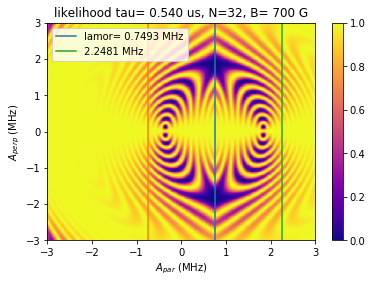

In [515]:
tau_i = 0.54e-6
B = 700
n_dd = 32
gamma_n = 1.0705e3 * 2*np.pi # 13-C, Hz rad
    
m_A_par =  np.linspace(-3*np.pi*2,3*np.pi*2, 500)  # MHz rad
m_A_perp = np.linspace(-3*np.pi*2,3*np.pi*2, 500)
x_grid, y_grid = np.meshgrid(m_A_par, m_A_perp)
    
x, y = get_likelihood_vs_w(tau_i, n_dd, x_grid.flatten(), y_grid.flatten(), b_gauss=B)
y_2d = y.reshape(len(m_A_par), len(m_A_perp))

plt.imshow(y_2d, vmin=0, extent=[m_A_par[0]/(2*np.pi), m_A_par[-1]/(2*np.pi),
                                 m_A_perp[0]/(2*np.pi), m_A_perp[-1]/(2*np.pi)],
           cmap='plasma', aspect='auto', origin='lower')
a_lamor = gamma_n*B/(2*np.pi*1e6)
plt.axvline(a_lamor, color='C0', label="lamor= {:.4f} MHz".format(a_lamor))
plt.axvline(-a_lamor, color='C1')
a_symm = 3*gamma_n*B/(2*np.pi*1e6)
plt.axvline(a_symm, color='C2', label="{:.4f} MHz".format(a_symm))

plt.xlabel("$A_{par}$ (MHz)")
plt.ylabel("$A_{perp}$ (MHz)")
plt.colorbar()
plt.legend()
plt.title("likelihood tau= {:.3f} us, N={}, B= {} G".format(tau_i*1e6, n_dd, B))
            
print(get_likelihood_vs_w(tau_i, n_dd, [-1], [-1]))

# Fisher information

In [6]:
def calc_fisher_information(t_us=1, n_dd=4, freq_min_mhz=0, freq_max_mhz=1, B_gauss=100, n_points=1000):

    fi_model = MultimodeDDModel(b_gauss=B_gauss)
    freq_max = 2*np.pi*freq_max_mhz  # mhz rad
    freq_min = 2*np.pi*freq_min_mhz

    fi_prior =  qi.UniformDistribution(np.asarray([[freq_min, freq_max],[freq_min, freq_max]]))
    fi = basic_SMCUpdater(fi_model, n_points, fi_prior, 
                                   resample_a=mfl_res_a, resample_thresh=mfl_res_th)



    expparams = np.empty((1,), dtype=[('t', '<f8'), ('n', '<i4'), ('w1', '<f8'), ('w2', '<f8')])  # tau (us)
    expparams['t'] = t_us
    expparams['n'] = n_dd
    expparams['w1'] = 0
    expparams['w2'] = 0

    fi_par, fi_perp, a_par, a_perp = fi.calc_fisher_information(None, expparams)
    
    return fi_par, fi_perp, a_par, a_perp  # [A]: Mhz rad

def calc_fisher_information_at_A(A_par_mhz, A_perp_mhz, t_us=1, n_dd=4, B_gauss=100):
    A_bigger = A_par_mhz if A_par_mhz > A_perp_mhz else A_perp_mhz
    A_smaller = A_par_mhz if A_par_mhz < A_perp_mhz else A_perp_mhz
    
    freq_max_mhz = 1.2*A_bigger
    freq_min_mhz = 0.8*A_smaller
    
    fi_par, fi_perp, a_par, a_perp = calc_fisher_information(t_us=t_us, n_dd=n_dd,
                                                             freq_min_mhz=freq_min_mhz, freq_max_mhz=freq_max_mhz, 
                                                             B_gauss=B_gauss, n_points=1000)
    
    idx_par = np.argmin(abs(a_par/(2*np.pi)-A_par_mhz))
    idx_perp = np.argmin(abs(a_perp/(2*np.pi)-A_perp_mhz))
    
    #print("t_us= {}, n_dd= {}. Debug: idx: {}, {}".format(t_us, n_dd, idx_par, idx_perp))
    
    return fi_par[idx_par, idx_perp], fi_perp[idx_par, idx_perp]

(8.706186882112176e-17, 9.564408712208638e-15)
1.1233731979806103e-12


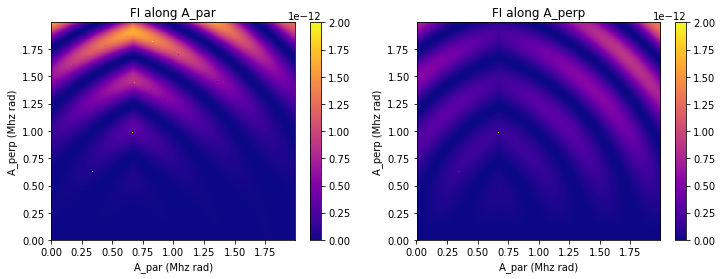

In [216]:
fi_par, fi_perp, a_par, a_perp = calc_fisher_information(t_us=1, n_dd=32, freq_max_mhz=2/(2*np.pi), B_gauss=100, n_points=1000)

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.imshow(fi_par, extent=[a_par[0], a_par[-1],
                                                 a_perp[0], a_perp[-1]],
                           cmap='plasma', aspect='auto', origin='lower', vmax=2e-12, vmin=0)
plt.title("FI along A_par")
plt.xlabel("A_par (Mhz rad)")
plt.ylabel("A_perp (Mhz rad)")
plt.colorbar()

plt.subplot(122)
plt.imshow(fi_perp, extent=[a_par[0], a_par[-1],
                                                 a_perp[0], a_perp[-1]],
                           cmap='plasma', aspect='auto', origin='lower', vmax=2e-12, vmin=0)
plt.title("FI along A_perp")
plt.xlabel("A_par (Mhz rad)")
plt.ylabel("A_perp (Mhz rad)")
plt.colorbar()

# ATTENTION: still some offset from mathematica!
print(calc_fisher_information_at_A(1/(2*np.pi), 1/(2*np.pi), n_dd=32))
print(fi_par[-1,-1])

## Optimize FI for given t_tot = N*tau

In an heuristic N*tau can be guessed (eg. from width of posterior)
Optimization assumes that we have good (in fact) perfect knowledge of A_par, A_perp. This is due to the dependence of FI(A) and we do not treat it statistically here.

In [138]:
n_dd = np.arange(2,100,2)
t_tot = 150e-6
tau = np.ones(len(n_dd))*(t_tot/n_dd)

A_par_mhz = 0.03/(2*np.pi)
A_perp_mhz = 0.02/(2*np.pi)

# this is slow as fuck, as we can't parallelize t_us, n_dd 
fi_list = [calc_fisher_information_at_A(A_par_mhz, A_perp_mhz, t_us=t*1e6, n_dd=n_dd[i]) for i, t in enumerate(tau)]

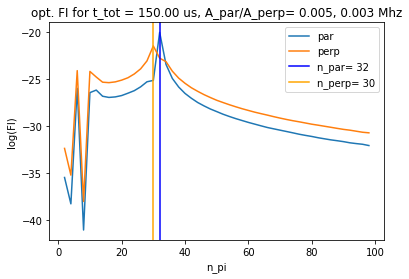

In [144]:
fi_par_vs_n = [el[0] for el in fi_list]
fi_perp_vs_n = [el[1] for el in fi_list]
idx_par_opt = np.argmax(fi_par_vs_n)
idx_perp_opt = np.argmax(fi_perp_vs_n)

plt.plot(n_dd, np.log(fi_par_vs_n), label="par")
plt.plot(n_dd, np.log(fi_perp_vs_n), label="perp")
plt.axvline(n_dd[idx_par_opt], color='blue', label="n_par= {}".format(n_dd[idx_par_opt]))
plt.axvline(n_dd[idx_perp_opt], color='orange', label="n_perp= {}".format(n_dd[idx_perp_opt]))
plt.legend()
plt.ylabel("log(FI)")
plt.xlabel("n_pi")
plt.title("opt. FI for t_tot = {:.2f} us, A_par/A_perp= {:.3f}, {:.3f} Mhz".format(
        t_tot*1e6, A_par_mhz, A_perp_mhz))
plt.show()

## Monte carlo lib

In [40]:
## Monte Carlo sensitivity without overhead
import pandas as pd

t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s


def monte_carlo_mfl_runs(n_mc, n_epcohs, n_sweeps):
    """
    repeat complete mfl run
    """
    global true_omega_1, true_omega_2
    
    dB_list = []
    tau_list = []
    n_list = []
    t_total_list = []
    err_list = []
    fi_list = []
    for i in range(0, n_mc):
        reset_result()
        # noise in run estimation done by sampling Gaussian
        # -> set global noise_n_rep
        try:
            (taus, B, dB, priors) = run_estimation(n_epochs=n_epochs, n_sweeps=1)  
        except NameError: # ApproximationError from mfl lib
            continue

        dB_list.append([ np.asarray([el[0,0] for el in dB]), np.asarray([el[1,1] for el in dB]) ])  # MHz rad
        tau_list.append(1e-9*np.asarray(taus)*n_sweeps)  # taus: ns -> t_phase: s
        err_list.append([np.asarray(B)[:,0] - true_omega_1, np.asarray(B)[:,1] - true_omega_2])
        n_list.append(np.asarray(track_n))
        fi_list.append(np.asarray(track_fi_diag))
    
    return dB_list, tau_list, err_list, n_list, fi_list

def estimate_final_db(n_mc, n_epochs, n_sweeps):
    dBs = sample_db_monte_carlo_mfl(n_mc)
    return np.median(dBs)

def calc_sensitivitiy(db, t_total):
    return db * np.sqrt(t_total)

def calc_t_total_ideal(tau_list):
    return np.sum(tau_list)

def estimate_runtime(tau_list_s, t_overhead_dict, n_sweeps=1):
    # see SI of Santagati (2018)
    # all units: SI
    n_epochs = len(tau_list_s)
    
    t_ov = t_overhead_dict
    
    t_total = 0
    for i in range(0, n_epochs):
        t_i = n_sweeps * tau_list_s[i][0] + t_ov['comp'] + t_ov['latency'] 
        t_total += t_i
        
    t_total += n_epochs * n_sweeps * (t_ov['t_laser'] + t_ov['t_wait'] + t_ov['t_mw'])
    
    return t_total


def b_mhzrad_to_ut(b):
    gamma = 2.8 # MHz per Gauss
    b_ut = (b / (2*np.pi)) / gamma    # Gauss
    b_ut = b_ut * 100 # uT
    
    return b_ut

def est_dB_ideal(n_epochs, n_sweeps, n_mc=100):
    """
    Runs monte carlo simulation for complete MFLs.
    Returns median values over all Monte Carlo samples.
    """
    dBs, t_phases, t_totals, errs = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    dB_est = np.median(dBs) # MHz rad
    err = np.median(errs)   # MHz rad

    dB_est_ut = b_mhzrad_to_ut(dB_est)
    err_est_ut = b_mhzrad_to_ut(err)
    
    t_phase = np.median(np.asarray(t_phases))   #s
    t_total = np.median(np.asarray(t_totals))
    
    return t_phase, t_total, dB_est_ut, err_est_ut     #s, s, uT, uT

def plot_example_sensitivity():
    n_mc = 100
    n_epochs = 50
    n_sweeps = 1
    
    # Example run for monte carlo sensitivity estimation
    dBs, taus, _, _ = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    plot_hist(dBs, label='dB after {} epochs'.format(n_epochs))
    plt.show()

    dB_est = np.median(dBs) # MHz rad
    gamma = 2.8e6*2*np.pi # MHz per Gauss
    dB_est_ut = (dB_est / (2*np.pi)) / gamma    # Gauss
    dB_est_ut = dB_est_ut * 100 # uT

    t_total = np.median(np.asarray(taus))   #s
    eta = calc_sensitivitiy(dB_est_ut, t_total)   # uT/sqrt(Hz)
    print("Median {:.2f} MHz rad, T_total {:.4f} ms, sensitivity^2: {:.4f} e-3 uT^2/Hz".format(dB_est, t_total*1e3, eta**2*1e3))


def est_dB_vs_t(n_epochs_max, n_sweeps, n_mc=5):
    ts_phase = []
    ts_total = []
    dbs = []
    errs = []
    for n_epoch in range(1, n_epochs_max):
        t, t_tot, dB, err = est_dB_ideal(n_epoch, n_sweeps, n_mc=n_mc)   #s, s, uT, uT
        #eta = calc_sensitivitiy(dB, t)   # uT/sqrt(Hz)
        
        ts_phase.append(t)
        ts_total.append(t_tot)
        dbs.append(dB)
        errs.append(err)
    
    return ts_phase, ts_total, dbs, errs
       
def plot_eta_sq_vs_t(ts, etas, ax=None, color='blue', label=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='eta^2 (uT^2/Hz)')
    ax.yaxis.set_label_position("left")
    ax.set_yscale('log')
    ax.set_xscale('log')


    ax.scatter(np.asarray(ts)*1e3, np.asarray(etas)**2, color=color, label=label)
    # errorplo

    #plt.legend()

    return ax

def plot_eta_vs_t(ts_s, etas_ntsqrthz, ax=None, color='blue', label=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='eta (nT/sqrt(Hz)')
    ax.yaxis.set_label_position("left")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(np.asarray(ts_s)*1e3, np.asarray(etas_ntsqrthz), color=color, label=label)
    return ax
  
def plot_err_vs_t(ts, errs_uT, trueB_mhzrad, ax=None, color='red', label=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='rel error est(B) - B')
    #ax.yaxis.set_label_position("right")
    ax.set_yscale('log')
    ax.set_xscale('log')

    # error
    rel_err = abs(np.asarray(errs_uT) / b_mhzrad_to_ut(trueB_mhzrad))
    #print("rel error {}".format(rel_err))
    ax.scatter(np.asarray(ts)*1e3, rel_err, color=color, label=label)
    ax.set_ylim([min(rel_err), max(rel_err)])
    #print("{} epochs: {} ms, {} uT^2/Hz".format(n_epoch, t*1e3, eta**2))

    #plt.legend()
    
    return ax

def plot_hor_line(value, color='green', label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axhline(value, color=color, label=label)
    
    return ax

def calc_stdmes_sensitivity(tau_s, t_total_s, t2star_s, c=1):
    # see Degen Reinhard 'Quantum Sensing'
    # optimal choice: tau = t2star / 2
    
    gamma = 2*np.pi*2.8e6 # -> Hz (rad) per Gauss
    t_m = t_total_s - tau_s
    
    decay = np.exp(tau_s/t2star_s)
    #print("decay f= {} tau: {}, t2*: {}".format(decay, tau_s, t2star_s))
    eta = decay*np.sqrt(tau_s + t_m)/(gamma*c*tau_s) # Gauss / sqrt(Hz)
        
    return 100*eta  # -> uT / sqrt(Hz)   

def calc_stdmes_sensitivity_opt(t2star_s, c=1):
     # Degen17, at optimum, t_m=0
    
    gamma = 2*np.pi*2.8e6 # -> Hz (rad) per Gauss
    eta = np.sqrt(2*np.exp(1))/(gamma*c*np.sqrt(t2star_s))
    
    # difference between Degen and Rondin: sqrt(2e) in numerator
    # comes from: there is decoherence, take ~T2* (Rondin)
    # vs. optimized exp(-tau/T2*) -> T2*/2 (Degen)
    #eta = 1/(gamma*c*np.sqrt(t2star_s))
    
    return 100*eta  # -> uT / sqrt(Hz)   

def calc_stdmes_sensitivity_opt_2(t2star_s, c=1):
    # Rondin17, with C*sqrt(I*t_l) = c from Degen17
    hbar = 6.63e-34 / (2*np.pi)
    mu = 9.274e-24
    g = 2
    
    return 1e6 * hbar / (g*mu*c*np.sqrt(t2star_s))    # -> uT / sqrt(Hz)   
    

def estimate_precision(n_mc, n_epochs, tolerate_rel_err=10e-2):
        
    n_sweeps = 1
    dB_list, t_phase_list, t_total_list, err_list = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    rel_error_list = np.asarray(err_list) / true_omega
    big_errors = rel_error_list[abs(rel_error_list) > tolerate_rel_error]
    
    return 1-len(big_errors)/float(n_mc), big_errors


def calc_tau_ramsey_bmax(b_max_mhz):
    
    gamma = 2*np.pi*2.8e6 # Hz (rad) per Gauss
    b_max_t = b_max_mhz *1e6 / (gamma / 2*np.pi)
    
    tau_s = 1 / (2*np.pi*gamma*b_max_t) # Waldherr 2012
    
    return tau_s


def calc_rolling_mean(x, y, rolling_window=None, subsampling_fraction=20):
    # shadows setup3 mfl_analysis_snippets.py

    # to pandas for a time series (data is unevenly spaced!)
    data_zip = zip(x, y)
    data_zip = sorted(data_zip, key = lambda x: x[0])
    
    #print(len(x))
    #print(len(y))
    
    eta_series = pd.DataFrame(data_zip, columns=['x', 'y'])
    eta_series.set_index(pd.DatetimeIndex(eta_series['x']))

    eta_series['date'] = pd.to_datetime(eta_series['x'], unit='s')
    eta_series.set_index('date', inplace=True)
    #print(eta_series[-10:])
    dt_window = rolling_window
    eta_mean = eta_series.rolling(dt_window, min_periods=1).median()
    eta_std_dev = eta_series.rolling(dt_window, min_periods=1).std()#

    # subsampling on right 3/4 of data
    if len(eta_mean) > 10e3:
        n_skip = int(len(eta_mean) / 10e3)
        n_split = int(len(eta_mean) / subsampling_fraction)
        eta_mean = pd.concat([eta_mean[0:n_split], eta_mean[n_split::n_skip]])
        eta_std_dev = pd.concat([eta_std_dev[0:n_split], eta_std_dev[n_split::n_skip]])

    x = np.asarray(eta_mean['x'].tolist())
    y = np.asarray(eta_mean['y'].tolist())
    dy = np.asarray(eta_std_dev['y'].tolist())
    #print(dy[-10:])

    return x, y, dy

def t_tot_2_tau(taus_tot, noise_n_rep):
    # reverse time accumulation
    taus_median = np.asarray(taus_tot)/noise_n_rep
    taus_median[1:] -= taus_median[:-1].copy()

    return taus_median

def average_sim(bs, dBs, taus, ndds, fi_list=None, t_ov=None, mov_avg_t_window=None, avg_mode='median', n_rep=1):

    """
    bs, dBs, taus: list of independent runs, eg. output of monte carlo sim
    """
    tau_list = taus
    
    if mov_avg_t_window == None:
        if dBs is not None:
            bs = np.asarray(bs)
            dBs = np.asarray(dBs)
        if fi_list is not None:
            fi_list = np.asarray(fi_list)
        #errs = np.asarray(errs)

        tau_list = np.asarray(tau_list)
        ndds = np.asarray(ndds)


        
        if avg_mode == 'median':
            #bs_median_mhz = np.median(bs, axis=0).flatten()/(2*np.pi)
            if dBs is not None:
                dBs_median_mhz = np.median(dBs, axis=0).transpose()/(2*np.pi)  # MHz
            if fi_list is not None:
                fis_median_mhz = np.median(fi_list, axis=0)
            #errs_median = np.median(errs, axis=0).flatten()
            taus_median = np.median(tau_list, axis=0)
            ndds_median = np.median(ndds, axis=0)
            t_evol_median = np.multiply(taus_median, ndds_median)

        elif avg_mode == 'average':
            #bs_median_mhz = np.average(bs, axis=0).flatten()/(2*np.pi)
            dBs_median_mhz = np.average(dBs, axis=0)/(2*np.pi)  # MHz
            #errs_median = np.average(errs, axis=0).flatten()
            taus_median = np.average(tau_list, axis=0)
            ndds_median = np.average(ndds, axis=0)
        else:
            raise ValueError("Unknown avg mode")
        if t_ov == None:
            taus_tot = calc_total_runtime(taus_median)*n_rep
            t_evol_tot = calc_total_runtime(t_evol_median)*n_rep
        else:
            taus_tot = estimate_runtime(taus_median, t_ov, n_rep)
        
        if dBs is not None and fi_list is None:
             return None, (dBs_median_mhz[:,0], dBs_median_mhz[:,1]), t_evol_tot, t_evol_median 
        elif dBs is None and fi_list is not None:
             return None, (fis_median_mhz[:,0], fis_median_mhz[:,1]), t_evol_tot, t_evol_median 
        else:
            raise ValueError("Either dB or fi, not both")
            
           
        
    else:
        if avg_mode != 'median':
            raise NotImplemented("Need to add non-median mode to calc_rolling_mean")
        if t_ov == None:
            taus_tot =    [calc_total_runtime(taus)*n_rep for i, taus in enumerate(tau_list)]
            t_evol_tot = []
            #t_evol_tot = [calc_total_runtime(np.multiply(np.asarray(taus), np.asarray(ndds[i])))*n_rep for i, taus in enumerate(tau_list)]                                  
        
            for i, taus in enumerate(tau_list):
                ns = ndds[i]
                t_evol_tot.append(calc_total_runtime(np.multiply(np.asarray(taus), np.asarray(ns)).flatten()*n_rep))

        else:
            raise NotImplemented("No overhead estimation")
        
        t_evol_tot = (np.asarray(t_evol_tot)).flatten()
        
        if dBs is not None and fi_list is None:
            #print(np.asarray(dBs).shape)
            dBs_1_mhz = (np.asarray(dBs)[:,0,:]/(2*np.pi)).flatten()
            dBs_2_mhz = (np.asarray(dBs)[:,1,:]/(2*np.pi)).flatten()

            bs_median_mhz = None
            t_evol_tot, dBs_1_median_mhz, _ = calc_rolling_mean(t_evol_tot, 
                                                               dBs_1_mhz, 
                                                              rolling_window=mov_avg_t_window)
            _, dBs_2_median_mhz, _ = calc_rolling_mean(t_evol_tot, 
                                                   dBs_2_mhz, 
                                                  rolling_window=mov_avg_t_window)
            
            t_evol = t_tot_2_tau(t_evol_tot, noise_n_rep)
            return bs_median_mhz, (dBs_1_median_mhz, dBs_2_median_mhz), t_evol_tot, t_evol
        
        elif fi_list is not None and dBs is None:
            fi_avg, fi_par, fi_perp = [], [], []
            for trace in fi_list:
                fi_avg.append([np.average(fi, axis=0) for fi in trace])
                fi_par.append([fi[0] for fi in trace])
                fi_perp.append([fi[1] for fi in trace])
            fi_par = np.asarray(fi_par).flatten()
            fi_perp = np.asarray(fi_perp).flatten()
            fi_avg = np.asarray(fi_avg).flatten()
                
            t_evol_tot, fi_par_median, _ = calc_rolling_mean(t_evol_tot, 
                                                   fi_par, 
                                                  rolling_window=mov_avg_t_window)
            _, fi_perp_median, _ = calc_rolling_mean(t_evol_tot, 
                                                   fi_perp, 
                                                  rolling_window=mov_avg_t_window)
            _, fi_avg_median, _ = calc_rolling_mean(t_evol_tot, 
                                                   fi_avg, 
                                                  rolling_window=mov_avg_t_window)
            
            #print(np.asarray(t_evol_tot).shape)
            #print(np.asarray(fi_par_median).shape)
            
            t_evol = t_tot_2_tau(t_evol_tot, n_rep)
            
            #print(np.asarray(t_evol_tot).shape)
            #print(np.asarray(t_evol).shape)
            
            return None, (fi_par_median, fi_perp_median, fi_avg_median), t_evol_tot, t_evol
            
        else:
            raise ValueError("Either dB or fi, not both")
            
            
        
        # todo: not working
        #_, bs_median, _ = calc_rolling_mean(taus_tot, 
        #                                    np.asarray(bs), 
        #                                    rolling_window=mov_avg_t_window)


        #taus_median = t_tot_2_tau(taus_tot, noise_n_rep)
        
    


print(calc_tau_ramsey_bmax(100))

2.5e-09



## Averaged multiple MFL runs

{'mfl_res_a': 0.98, 'mfl_res_th': 0.7, 'true_omega_1': 0.12566370614359174, 'true_omega_2': 0.3141592653589793, 'freq_min': 0, 'freq_min_1': 3.141592653589793, 'freq_max': 3.141592653589793, 'phi_max': 3.141592653589793, 't2star_s': 0, 'n_particles': 10000, 'noise_mode': None, 'noise_c': 0.03, 'noise_n_rep': 1, 'noise_photons_0': 0.04, 'noise_photons_1': 0.032, 'binarize_mode': 'majority', 'exp_mode': 'dd', 'hahn_b_gauss': 300, 't2_a_dd_s': 0.0005, 't2_b_dd_s': 0.0005, 'n_pi_dd_max': 8000, 'n_dd_mod': 2}
Epoch 0, t_tot: [5.41665827] us


C:\Users\Timo\OneDrive\_Promotion\Software\MFL_repo\mfl_sensing_simplelib.py:3856: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(p1*(1-p1))*d_p1_par**2, 1/(p1*(1-p1))*d_p1_perp**2, w1, w2
C:\Users\Timo\OneDrive\_Promotion\Software\MFL_repo\mfl_sensing_simplelib.py:3856: RuntimeWarning: invalid value encountered in multiply
  return 1/(p1*(1-p1))*d_p1_par**2, 1/(p1*(1-p1))*d_p1_perp**2, w1, w2


Epoch 100, t_tot: [33.1727656] us
Epoch 0, t_tot: [5.4313123] us
Epoch 100, t_tot: [582.57227388] us
Epoch 0, t_tot: [5.45503924] us
Epoch 100, t_tot: [438.27154876] us
Epoch 0, t_tot: [5.4418885] us
Epoch 100, t_tot: [907.41079757] us
Epoch 0, t_tot: [5.4394028] us
Epoch 100, t_tot: [796.94514345] us


No handles with labels found to put in legend.
No handles with labels found to put in legend.


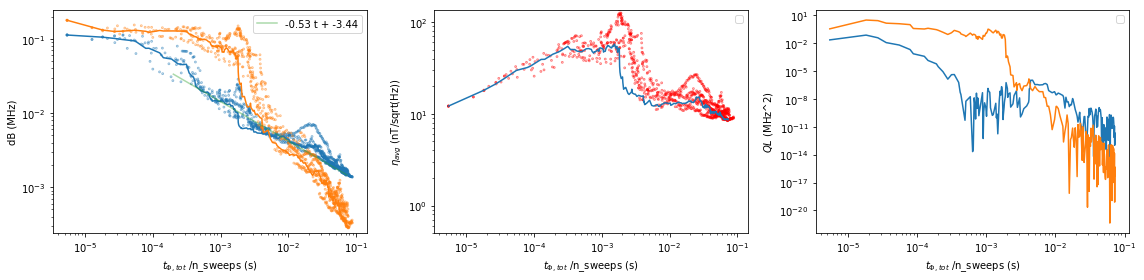

No handles with labels found to put in legend.


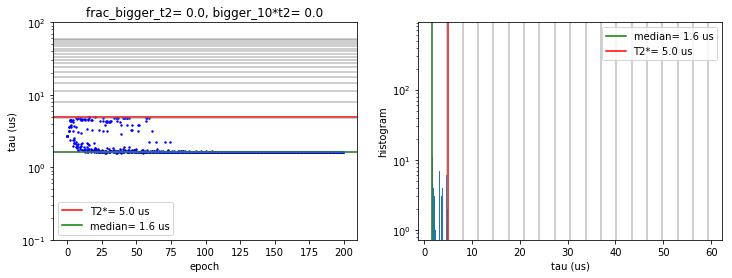

No handles with labels found to put in legend.


Averaging window t= 0.1ms


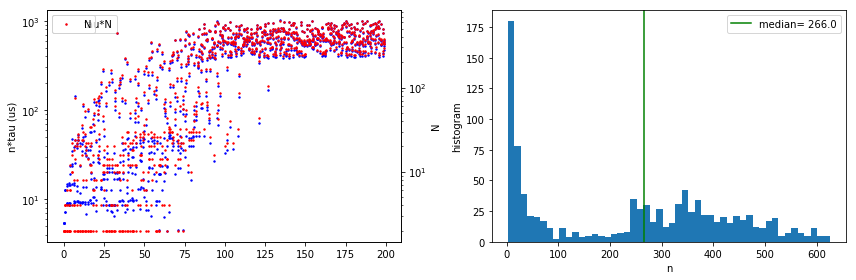

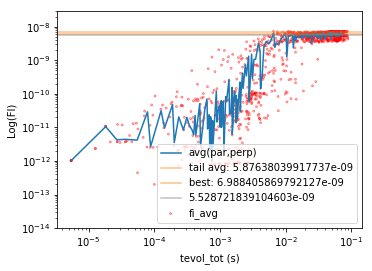

In [140]:
set_common_params()

"""
freq_max = 2*np.pi*a_lamor # MHz rad, MUST BE < LAMOR
freq_min = 0
freq_min_1 = 2*np.pi*0.5

true_omega_1 = -2*np.pi*0.7  #0.6
true_omega_2 = 2*np.pi*0.1   #np.pi/2
true_params = np.array([[true_omega_1, true_omega_2]])
"""
#true_omega_1 = -2*np.pi*0.7
#true_omega_2 = 2*np.pi*0.1
#true_params = np.array([[true_omega_1, true_omega_2]])

t_overhead = {'comp':0e-3, 'latency':0e-6, 't_laser':0e-9, 't_wait':0e-9, 't_mw':0e-9}   # s
n_sweeps = 1  # not for noise, only calc t

exp_mode = 'dd'
hahn_b_gauss = 300

t2star_s = 0 #10e-6
t2a_s = 500e-6
t2b_s = 500e-6

# monte carlo params
n_epochs = 200#750   #1500
n_pi_dd_max = 8000
n_mc = 5 # 10 # 500
mov_avg_t_window = "0.1ms"

# noise params
noise_mode = None #'Gauss'
noise_c = 0.03
noise_n_rep = 1#1.5e3

print(get_params())
dBs, tau_list, errs, n_list, fi_list = monte_carlo_mfl_runs(n_mc, n_epochs, n_sweeps)

t_evol_list = []
for i, taus in enumerate(tau_list):
    ns = n_list[i]
    t_evol_list.append(np.multiply(np.asarray(taus), np.asarray(ns)).flatten())

# BROKEN ROLL MEAN
"""
_, fis_median, tevol_tot, tevol = average_sim(None, None, tau_list, n_list, fi_list=fi_list,
                                              mov_avg_t_window=mov_avg_t_window, n_rep=noise_n_rep)
_, dBs_median, tevol_tot, tevol = average_sim(None, dBs, tau_list, n_list, fi_list=None,
                                              mov_avg_t_window=mov_avg_t_window, n_rep=noise_n_rep)

"""
# WORKS, MEDIAN PER EPOCH (TODO: DOUBLE CHECK)
#"""
_, fis_median, tevol_tot, tevol = average_sim(None, None, tau_list, n_list, fi_list=fi_list,
                                              mov_avg_t_window=None, n_rep=noise_n_rep)
_, dBs_median, tevol_tot, tevol = average_sim(None, dBs, tau_list, n_list, fi_list=None,
                                              mov_avg_t_window=None, n_rep=noise_n_rep)
#"""
fis_median = [(fis_median[0][i], fis_median[1][i]) for i, el in enumerate(fis_median[0])]
dBs_median = np.asarray([(dBs_median[0][i], dBs_median[1][i]) for i, el in enumerate(dBs_median[0])])
tau_median_allruns = np.median(np.asarray(tau_list).flatten())



#plt.plot(tevol_tot, dBs_median[:,1])
#ax = plt.gca()
#ax.set_xscale('log')
#ax.set_yscale('log')
#plt.show()

#print(fis_median[100])
#print(dBs_median.shape)



plot_scaling(tevol, dBs_median, None, 
             tevol_scatter=t_evol_list, dB_mhz_scatter=np.asarray(dBs)/(2*np.pi))
#taus_tot = calc_total_runtime(taus_median)
taus_res = est_tau_res(true_omega_1/(2*np.pi), hahn_b_gauss, np.asarray(range(1, 20, 1)))

plot_taus(1e9*np.asarray(tau_list), t_filter_s= 50e-6, hlines=taus_res)
#plot_taus([1e9*taus_median], t_filter_s= 50e-6, hlines=taus_res)
#plot_taus_ns([n_median.flatten()], [1e9*taus_median.flatten()])
plot_taus_ns(np.asarray(n_list), 1e9*np.asarray(tau_list))

#print(np.asarray(fis_avg_median).shape)
#print(np.asarray(tevol_tot).shape)
#print(np.asarray(tevol).shape)

#fi_opt, tau_opt, n_opt = calc_best_fisher(tau_median_allruns)
#print("Best FI (par, perp, sum) @ tau= {}/ {}/ {} us, n_dd= {}/ {}/ {}".format(tau_opt[0]*1e6, tau_opt[1]*1e6, tau_opt[2]*1e6,
#                                                                               n_opt[0], n_opt[1], n_opt[2]))

#print(np.asarray(tau_list))
#print(np.asarray(n_list))



#print(t_evol_list)
fi_avg_list = np.asarray([np.average(fi, axis=1) for fi in fi_list])
print("Averaging window t= {}".format(mov_avg_t_window))
plot_fisher(fis_median, t_evol=tevol, hlines=[fi_opt[2]],
            tevol_scatter=t_evol_list, fi_avg_scatter=fi_avg_list.flatten(),
            n_rep=noise_n_rep)




## Precompute tau list

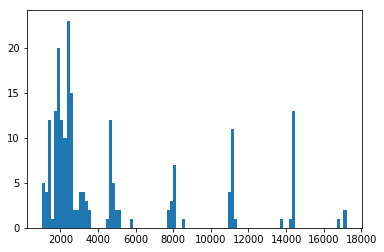

For T2= 2000.0 us, n_dd_max= 1285: sigma_tau= 2.4224303289143464e-09 -> dtau= 2.4e-09, len(tau_list)= 202
202


In [250]:
def tau_list_from_sim_res(tau_list, t2=2e-3, B=500):
    """
    From a simulation run, take tau list and filter all empirical taus
    such that we can resolve the minimum expected linewidth at T2
    """
    n_dd = np.arange(0, 5, 1)
    tau_res_est = heuristic.calc_tau_k(A_par_mhz, n_dd, no_warning=True, b_gauss=B)
    tau_min = np.min(tau_res_est)
    n_dd_max = int(t2/tau_min)

    sigma_tau_min = heuristic.estimate_tau_res_width(tau_min, n_dd_max)

    tolerance = np.round(sigma_tau_min*1e10)*1e-10

    a = np.asarray(tau_list).flatten()
    i = np.argsort(a.flat)
    d = np.append(True, np.diff(a.flat[i]))
    result = a.flat[i[d>tolerance]]

    plt.hist(result*1e9, bins=100)
    plt.show()

    tau_list_out = np.unique(result)
    
    print("For T2= {} us, n_dd_max= {}: sigma_tau= {} -> dtau= {}, len(tau_list)= {}".format(
        t2*1e6, n_dd_max, sigma_tau_min, tolerance, len(tau_list_out)))
    
    return tau_list_out
    
tau_out = tau_list_from_sim_res(tau_list, t2=2e-3, B=300)

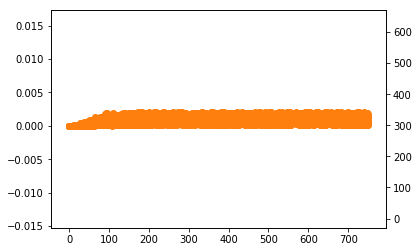

In [322]:
ns = np.asarray(n_list)
taus = np.asarray(taus)
for i in range(0, len(ns[:,0])):
        tau = taus[i]
        n = ns[i]
        if i == 0:
            ax1 = plt.gca()
            ax2 = ax1.twinx()
        x_epochs = range(0, len(n))
        #print("{} {}".format(i, np.multiply(n,tau)))
        ax1.scatter(x_epochs, np.multiply(n,tau), color='C1')
        ax2.scatter(x_epochs, n,tau, color='C1')
plt.show()
     

In [210]:
taus = np.asarray(taus_median).flatten()
ns = np.asarray(n_median).flatten()
#print(ns.shape)
#print(taus.shape)
#print(t_phi_tot)
t_phi_tot = calc_total_runtime(np.multiply(taus, ns))
#print(np.average(fi_median,axis=1))


np.savetxt(r"C:\Users\Timo\Desktop\taus.txt", t_phi_tot)
np.savetxt(r"C:\Users\Timo\Desktop\fi.txt", np.average(fi_median,axis=1))

In [423]:
def calc_tau_k(self, A_par_mhz, k_order=1):
        # (Taminiau (2012), valid for high B (w_l >> w_h)
        # note: definition of tau = 1/2 tau_taminiau
        omega_l = 300 * 1.07084e3 * 2 * np.pi  # 13-C, Hz/G, [w] = Hz rad
        k_order = np.asarray(k_order)
        
        #print(omega_l/(1e6*2*np.pi))
        if A_par_mhz*1e6 > (omega_l/(2*np.pi)):
            print("WARNING: Approximation invalid for low B")

        tau_res = 2*(2*k_order-1)*np.pi/(2*omega_l+2*np.pi*A_par_mhz*1e6)
        try:
            tau_res[k_order==0] = np.pi/omega_l
        except TypeError:
            if k_order == 0: return np.pi/omega_l

        return tau_res

        

def round_up_to_even(self, f):
    rounded = np.round(f/2.)*2
    rounded[rounded<= 0] = 2
    
    return rounded

def estimate_tau_res_width(self, tau_res_k_1, n_dd):
    sigma_f = 1 / (tau_res_k_1*n_dd)
    center_f = 1/tau_res_k_1
    left_f = center_f - sigma_f
    right_f = center_f + sigma_f
    
    return abs(1/(right_f) - 1/(left_f))

omega_test_mhz = 0.05
t_tot_us = 27e-6

k_res = np.arange(0, 5, 1)
n_points = 5

tau_res = calc_tau_k(None, omega_test_mhz, k_res)
n_dd = round_up_to_even(None, np.ones(len(tau_res)) * t_tot_us / (tau_res * 1e6))

sigma_tau = 2 / (n_dd / 2) * 1e-6  # todo: only empirically

add_taus, add_ns = [], []
for i, tau in enumerate(tau_res):
    if tau - sigma_tau[i] < 100e-9:
        continue
    add_tau_i = np.linspace(tau - sigma_tau[i], tau + sigma_tau[i], n_points)
    add_taus.append(add_tau_i)
    add_n_i = round_up_to_even(None, np.ones(len(tau_res)) * t_tot_us / (add_tau_i * 1e6))
    add_ns.append(add_n_i)

sigma_tau = estimate_tau_res_width(None, 1.5e-6, n_dd)
#tau_res = np.concatenate([tau_res, np.asarray(add_taus).flatten()])
#n_dd = np.concatenate([n_dd, np.asarray(add_ns).flatten()])

print(n_dd)
print(tau_res)
print(sigma_tau)
print(np.multiply(tau_res, n_dd))

[2. 2. 2. 2. 2.]
[1.55641054e-06 1.44403498e-06 4.33210494e-06 7.22017490e-06
 1.01082449e-05]
[2.e-06 2.e-06 2.e-06 2.e-06 2.e-06]
[3.11282109e-06 2.88806996e-06 8.66420988e-06 1.44403498e-05
 2.02164897e-05]


# Ideal sensitivity

In [211]:
def calc_stdmes_sensitivity_opt(t2star_s, c=1):
     # Degen17, at optimum, t_m=0
    
    gamma = 2*np.pi*2.8e6 # -> Hz (rad) per Gauss
    eta = np.sqrt(2*np.exp(1))/(gamma*c*np.sqrt(t2star_s))
    
    # difference between Degen and Rondin: sqrt(2e) in numerator
    # comes from: there is decoherence, take ~T2* (Rondin)
    # vs. optimized exp(-tau/T2*) -> T2*/2 (Degen)
    #eta = 1/(gamma*c*np.sqrt(t2star_s))
    
    return 100*eta  # -> uT / sqrt(Hz)   

def eta_factor_theo(n):
    """
    Expected factor when comparing eta(t_avg) vs eta(t_max)
    """
    return np.sqrt(n)*np.sqrt(np.log(n+0.5))

calc_stdmes_sensitivity_opt(500e-6)*1e3
#eta_factor_theo(16)

0.5927060181017582

# Classical double tau, N sweep sensitivity

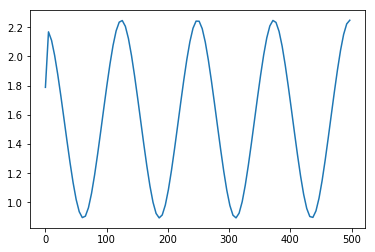

In [227]:
A_mhz = np.linspace(0,500-3,100)
plt.plot(A_mhz, phi_in_nsweep(1e-6, 0, A_mhz, 300))

In [8]:
import scipy

def func_sine(tau, a, f, y0, phi):
    return y0 + (a*np.sin(2*np.pi*f*tau + phi))

def sim_single_exp(tau, n_dd=4, b_gauss=100, apar_mhz=1, aperp_mhz=1):
    """
    Simulate with (binomial) quantum projection noise.
    """
    model = MultimodeDDModel(b_gauss=b_gauss)
    params = np.zeros((1, 2))
    params[:,0] = 2*np.pi*apar_mhz
    params[:,1] = 2*np.pi*aperp_mhz
    
    prior = build_initial_prior()
    # dummy init
    updater = basic_SMCUpdater(model, 100, prior, 
                                resample_a=0.5, resample_thresh=0.5)

    experiment = np.empty((1,), dtype=updater.model.expparams_dtype)
    experiment['n'] = n_dd
    experiment['t'] = tau*1e6
    
    # simulate quantum projection noise only    
    datum, datum_no_noise = exp_result(model, params, experiment, n_sweeps=1)
    datum_bin, datum_no_noise_bin = binarize_result(datum, mode='rand_coin'), \
                                    binarize_result(datum_no_noise, mode='majority')
    
    return 1-datum_no_noise, 1-datum_bin

def fit_sine(tau, data, init_f=8e3):
    
    init_guess = np.array([1, init_f, 0.5, np.pi])
    param, param_cov = scipy.optimize.curve_fit(func_sine, tau, data, init_guess) 
    
    return param, np.sqrt(np.diag(param_cov))

def fit_n_sweep(tau_0, data, A_par_mhz, B_gauss, n_dd, init_Aperp=0.13):
    init_guess = np.array([init_Aperp, 0.01, 0.9])
    bounds = ([0,0,0.5], [5,2,5])
    
    # lamda to fix known params
    def func_sine_in_nsweeps_fix_param(n_dd, a_perp_mhz, y0, a):
        return func_sine_in_nsweep(tau_0, A_par_mhz, a_perp_mhz, B_gauss, n_dd, y0, a)

    param, param_cov = scipy.optimize.curve_fit(func_sine_in_nsweeps_fix_param,
                                                n_dd, data, p0=init_guess, bounds=bounds, ftol=1e-10) # verbose=2, 
    
    return param, np.sqrt(np.diag(param_cov))

def fit_n_sweep_highB(tau_0, data, A_par_mhz, B_gauss, n_dd, init_Aperp=0.13):
    # only valid on resonance!
    init_guess = np.array([init_Aperp, 0.01, 0.9])
    bounds = ([0,0,0.5], [5,2,5])
    
    # lamda to fix known params
    def func_sine_in_nsweeps_fix_param_highB(n_dd, a_perp_mhz, y0, a):
        return func_sine_in_nsweep_highB(tau_0, A_par_mhz, a_perp_mhz, B_gauss, n_dd, y0, a)
    
    param, param_cov = scipy.optimize.curve_fit(func_sine_in_nsweeps_fix_param_highB,
                                                n_dd, data, p0=init_guess, bounds=bounds, ftol=1e-10)  # verbose=2, 
    
    
    return param, np.sqrt(np.diag(param_cov))


def func_sine_in_nsweep(tau_0, A_par_mhz, A_perp_mhz, B_gauss, n_dd, y0, a):
        
    phi = phi_in_nsweep(tau_0, A_par_mhz, A_perp_mhz, B_gauss)
    ampl = ampl_in_sweep(tau_0, A_par_mhz, A_perp_mhz, B_gauss)
    #print(phi.shape)
    return y0 + a*(1-ampl*(np.sin(n_dd*phi/2))**2)

def func_sine_in_nsweep_highB(tau_0, A_par_mhz, A_perp_mhz, B_gauss, n_dd, y0 ,a):

    phi = phi_in_nsweep_highB(tau_0, A_par_mhz, A_perp_mhz, B_gauss)
    ampl = 1
    #print(phi.shape)
    return y0 + a*(1-ampl*(np.sin(n_dd*phi/2))**2)

def exp_n_sweep(ns, tau_i, B_gauss, n_sweeps=1, apar_mhz=1, aperp_mhz=1):
    res = np.zeros((len(ns), n_sweeps))
    time = np.zeros((len(ns), n_sweeps))
    res_bin = np.zeros((len(ns), n_sweeps), dtype=float)
    
    t_tot = 0
    # todo: inefficient
    for j in range(n_sweeps):
        for i, n in enumerate(ns): 
            #res[i,j] = sim_single_exp(tau_i, n, b_gauss=B_gauss, apar_mhz=apar_mhz, aperp_mhz=aperp_mhz)[0]
            res_bin[i,j] = sim_single_exp(tau_i, n, b_gauss=B_gauss, apar_mhz=apar_mhz, aperp_mhz=aperp_mhz)[1]
            time[i,j] = (n)*tau_i
            
            t_tot += (n)*tau_i
    
    # t_evol, z_bin, t_tot of sweep (incl repetition for n_sweeps), z_bin
    return np.average(time, axis=1), np.average(res_bin, axis=1), t_tot


def phi_in_nsweep(tau_0, A_par_mhz, A_perp_mhz, B_gauss):
    # todo: lamor + or - A_par !? (Zhao vs Taminiau)
    gamma = 1.0705e3 * 2*np.pi # 13-C
    
    w_lamor = B_gauss * gamma # Hz rad
    w_t = np.sqrt((-(1e6*A_par_mhz*2*np.pi)+w_lamor)**2+(1e6*A_perp_mhz*2*np.pi)**2)
    
    alpha = w_t*tau_0/2   # tau definition in Taminiau differs!
    beta = w_lamor*tau_0/2
    
    m_z = (-2*np.pi*A_par_mhz*1e6+ w_lamor)/w_t 

       
    # see Taminiau (2012) Supl
    phi = np.arccos(np.cos(alpha)*np.cos(beta) - m_z*np.sin(alpha)*np.sin(beta))
    return phi

def phi_in_nsweep_highB(tau_0, A_par_mhz, A_perp_mhz, B_gauss):
    """
    Valid if A,B << w_lamor and directly on resonance (Delta=0)
    """
    # todo: lamor + or - A_par !? (Zhao vs Taminiau)
    gamma = 1.0705e3 * 2*np.pi # 13-C
    
    w_lamor = B_gauss * gamma # Hz rad
    w_t = np.sqrt((-(1e6*A_par_mhz*2*np.pi)+w_lamor)**2+(1e6*A_perp_mhz*2*np.pi)**2)
    
    m_z = (-2*np.pi*A_par_mhz*1e6+ w_lamor)/w_t 
    m_x = A_perp_mhz*2*np.pi*1e6 / w_t

       
    # see Taminiau (2012) Supl
    phi = m_x  # assuming delta_k~ Delta = 0
    return phi

def ampl_in_sweep(tau_0, A_par_mhz, A_perp_mhz, B_gauss):
    gamma = 1.0705e3 * 2*np.pi # 13-C
    
    w_lamor = B_gauss * gamma # Hz rad
    w_t = np.sqrt((-(1e6*A_par_mhz*2*np.pi)+w_lamor)**2+(1e6*A_perp_mhz*2*np.pi)**2)
    
    alpha = w_t*tau_0/2   # tau definition in Taminiau differs!
    beta = w_lamor*tau_0/2
    
    m_z = (-2*np.pi*A_par_mhz*1e6+ w_lamor)/w_t 
    m_x = A_perp_mhz*2*np.pi*1e6 / w_t
 
    # see Taminiau (2012) Supl
    
    one_minus_n0n1 = 0.5*m_x**2*(1-np.cos(alpha)*(1-np.cos(beta)))\
                    /(1+np.cos(alpha)*np.cos(beta)-m_z*np.sin(alpha)*np.sin(beta))
    return one_minus_n0n1

def f_in_nsweep_to_A(f, tau_0, A_par_mhz, B_gauss, A_perp_mhz_min=0, A_perp_mhz_max=5):
    """
    Numerically invert f(A_perp) to get A_perp (MHz).
    Note y = sin(n_dd * Phi/2)^2 -> f= Phi/2*pi
    """
    A_perps = np.linspace(A_perp_mhz_min, A_perp_mhz_max, 10000)
    phis = phi_in_nsweep(tau_0, A_par_mhz, A_perps, B_gauss)
    
    fs = np.ones((len(phis))) * f
    
    idx = np.argmin(abs(fs-phis))
    
    return phis[idx]/(2*2*np.pi)#*tau_0)

def df_in_sweep_to_dA(f, df, A_perp_mhz, tau_0, A_par_mhz, B_gauss, A_perp_mhz_max=5):
    # SEEMS BROKEN
    # due to resolution in numerical calculation of As!?
    A = A_perp_mhz
    A_1 = f_in_nsweep_to_A(f-df, tau_0, A_par_mhz, B_gauss, A_perp_mhz_max=1.01*A, A_perp_mhz_min=0.99*A)
    A_2 = f_in_nsweep_to_A(f+df, tau_0, A_par_mhz, B_gauss, A_perp_mhz_max=1.01*A, A_perp_mhz_min=0.99*A)
    print("A {}, f {}, df {}, f-df {}, f1 {}, dA1 {}".format(A, f, df, f-df, A_1, abs(A_1-A)))
    
    """
    slope_1 = abs(A_1-A)/df 
    slope_2 = abs(A_2-A)/df
    
    dA_1 = slope_1*df
    """
    
    return (abs(A-A_1)+abs(A-A_2))/2

### Params
B_gauss = 500
k_order = 0
n_dd_find_res = 4
ndd_list = np.arange(2,100,2)
# resonancens:
# 240 kHz -> 6.95e-6 (k=3), 4e-6 (k=2), 1.5e-6 (k=1)
# 120 kHz -> 7.6 (k=3)
m_A_i = 2*np.pi*100e3   #130e3  # Hz rad
tau_i = 900e-9 #7.6e-6
tau_i_est = heuristic.calc_tau_k(0/(2*np.pi), b_gauss=B_gauss, k_order=k_order)

alpha = np.pi/2  # pi/2 -> m_a_i=0
m_a_par_i = np.cos(alpha)*m_A_i
m_a_perp_i = np.sin(alpha)*m_A_i


### Resonances in tau scan
tau = np.linspace(0,3*tau_i,100)

plt.plot(tau*1e6, likelihood_dd(m_A_i, tau, n_dd_find_res, B=B_gauss, alpha=alpha),
         label="A_par/perp= {:.2f}/ {:.2f} kHz".format(m_a_par_i/(2*np.pi*1e3),m_a_perp_i/(2*np.pi*1e3)))
plt.plot(tau*1e6, likelihood_dd_taminiau(m_A_i, tau, n_dd_find_res, B=B_gauss, alpha=alpha), label="Taminiau")

plt.legend()
plt.xlabel("tau (us)")
plt.axvline(tau_i*1e6)
plt.axvline(tau_i_est*1e6, color='grey', alpha=0.5, label='est')

### Examplary n_sweep plot from likelihood
#ns = np.linspace(1,16,16)  # odd n code is still buggy!


plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(r'B= {:d} G, $\alpha$= {:.2f} rad/pi, tau= {} us'.format(
         B_gauss, alpha/np.pi, tau_i*1e6))
res = np.zeros(len(ndd_list))
time = np.zeros(len(ndd_list))
res_bin = np.zeros(len(ndd_list))


for i, n in enumerate(ndd_list): 
    res[i] = likelihood_dd(m_A_i, tau_i, n, B=B_gauss, alpha=alpha)
    res_bin[i] = sim_single_exp(tau_i, n, b_gauss=B_gauss, apar_mhz=m_a_par_i/(1e6*2*np.pi), aperp_mhz=m_a_perp_i/(1e6*2*np.pi))[1]
    time[i] = (n)*tau_i

# FFT of nsweep
n_zero_padding = 4096
fft_val = abs(np.fft.rfft(res, n=n_zero_padding))
# Prefactor shouldn't be needed anymore
kappa_fit_aperp = 1#4*2*np.pi  # need to tune for every k, A_perp atm!
if kappa_fit_aperp != 1:
    print("Warning: using calibration kappa= {} to extract A_perp from sine fit".format(kappa_fit_aperp))
freq = kappa_fit_aperp*np.fft.rfftfreq(n_zero_padding, time[2]-time[1])
freq_max = freq[100:][np.argmax(fft_val[100:])]


params, p_cov = fit_sine(time, res_bin, init_f=freq_max)

# plot in t domain
plt.plot(time*1e6, res, label="|A|= {:.1f}, A_par= {:.1f}, A_perp= {:.1f} kHz".format(m_A_i/(2*np.pi*1e3),m_a_par_i/(2*np.pi*1e3),m_a_perp_i/(2*np.pi*1e3)))
plt.scatter(time*1e6, res_bin)
plt.plot(time*1e6, func_sine(time, params[0], params[1], params[2], params[3]), color='orange', label="fit")

plt.xlabel(r"$t_{evol}$ (us)")
plt.legend()
# plot FFT
plt.subplot(122)
plt.title(r'FFT'.format(
         B_gauss, alpha/np.pi, m_a_par_i/(2*np.pi*1e6), m_a_perp_i/(2*np.pi*1e6)))
plt.plot(freq/1e3, fft_val)

plt.axvline(freq_max/1e3, label="freq= {} kHz".format(freq_max/1e3))
plt.xlabel("f (kHz)")
plt.legend()
plt.show()


# plot to check fitting and exp simulation
#"""

# data
exp_t, exp_z, t_tot = exp_n_sweep(ndd_list, tau_i, B_gauss, n_sweeps=100,
                                  apar_mhz=m_a_par_i/(2*np.pi*1e6), aperp_mhz=m_a_perp_i/(2*np.pi*1e6))

# fit simple sine and calculate from its frequency
params, p_cov = fit_sine(exp_t, exp_z, init_f=freq_max)
plt.plot(exp_t*1e6, func_sine(time, params[0], params[1], params[2], params[3]), color='orange', label="fit simple sine")
print("Simple sine fit")
print(params)
f_fit = params[1]
df_fit = p_cov[1]
A_perp_fit = f_in_nsweep_to_A(f_fit/kappa_fit_aperp, tau_i, 0, B_gauss)
print("A_perp_simple_fit: {} Mhz".format(A_perp_fit))

# fit whole model 
#print(m_a_par_i)
#"""
params, p_cov = fit_n_sweep(tau_i, exp_z, 1e-6*m_a_par_i/(2*np.pi), B_gauss, ndd_list)
A_perp_fit_mhz = params[0]
print("model fit")
print(params)
print("std")
print(np.sqrt(p_cov))

# plot model with known input A_perp -> should always reproduce data
#plt.plot(exp_t*1e6, func_sine_in_nsweep(tau_i, m_a_par_i/(2*np.pi*1e6), m_a_perp_i/(2*np.pi*1e6), B_gauss, ndd_list, 0, 1), color='red', label="test")


plt.plot(time*1e6, func_sine_in_nsweep(tau_i, 0, A_perp_fit_mhz, B_gauss, ndd_list, 0, 1)
         , color='purple', label="fit full model")
plt.plot(exp_t*1e6, exp_z, label="sig_z")
plt.legend()
plt.show()
#"""

# fit approx model at high B
params, p_cov = fit_n_sweep_highB(tau_i, exp_z, 1e-6*m_a_par_i/(2*np.pi), B_gauss, ndd_list)
A_perp_fit_mhz = params[0]
y0_fit = params[1]
a_fit = params[2]
print("high B model fit")
print(params)

# plot model with known input A_perp -> should always reproduce data
#plt.plot(exp_t*1e6, func_sine_in_nsweep(tau_i, m_a_par_i/(2*np.pi*1e6), m_a_perp_i/(2*np.pi*1e6), B_gauss, ndd_list, 0, 1), color='red', label="test")


plt.plot(time*1e6, func_sine_in_nsweep_highB(tau_i, 0, A_perp_fit_mhz, B_gauss, ndd_list, y0_fit, a_fit)
         , color='purple', label="fit highB model")
plt.plot(exp_t*1e6, exp_z, label="data: sig_z")
plt.legend()
plt.show()

plt.figure()
plt.plot(ndd_list, func_sine_in_nsweep_highB(tau_i, 0, A_perp_fit_mhz, B_gauss, ndd_list, y0_fit, a_fit), label="high B model")
plt.plot(ndd_list, exp_z, label="data: sig_z")
plt.legend()
plt.show()

#func_sine_in_nsweep(tau_0, A_par_mhz, A_perp_mhz, B_gauss, n_dd, y0 ,a)




#"""

n_dd = np.arange(0,64,4)

#"""
dA, ts = [], []
fs, dfs = [], []
sweeps = np.linspace(50, 5000, 25)
for n_s in sweeps:
    # TODO: NOT CORRECT, need to manually calibrate prefactor every time!
    #try:
    exp_t, exp_z, t = exp_n_sweep(n_dd, tau_i, B_gauss, n_sweeps=int(n_s), apar_mhz=m_a_par_i/(2*np.pi*1e6), aperp_mhz=m_a_perp_i/(2*np.pi*1e6))
    params, p_std = fit_n_sweep(tau_i, exp_z, 1e-6*m_a_par_i/(2*np.pi), B_gauss, n_dd, init_Aperp=1e-6*m_a_perp_i/(2*np.pi))
    #f = params[0]
    #df = p_std[0]
    #except:
    #    f = 0
    #    df = np.inf
    

    #A_i= 1e6*f_in_nsweep_to_A(f, tau_i, 0, B_gauss)
    A_i = params[0]*2*np.pi*1e6  # Mhz
    # todo: double check this!
    factor = A_i/f
    #dA_i = df* factor
    dA_i = p_std[0]*2*np.pi*1e6
    dA.append(dA_i)
    #df.append(kappa_fit_aperp*p_std[1])
    # debug
    #dfs.append(df)
    #fs.append(f)
    ts.append(t)
#""" 
#"""
#print(fs)
#print(dfs)
print(dA)
#print(df_in_sweep_to_dA(fs[0], dfs[0], 240e-3, tau_i, 0, B_gauss))
#print(df_in_sweep_to_dA(fs[1], dfs[1], 240e-3, tau_i, 0, B_gauss))
#"""
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(ts, np.asarray(dA)/1e6)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("t_tot (s)")
plt.ylabel("dB (MHz)")



plt.subplot(122)
gamma = 2*np.pi*2.8e6 # Hz rad / Gauss
dB = np.asarray(dA) / gamma * 1e5
eta_nT = np.sqrt(ts)*dB
plt.plot(ts, eta_nT)
plt.axhline(np.average(eta_nT), label=r"$\eta$= {:.2f} nT/sqrt(Hz)".format(np.average(eta_nT)))
plt.legend()
plt.xlabel("t_tot (s)")
plt.ylabel(r"$\eta$ (nT/sqrt(Hz))")

eta_avg = calc_stdmes_sensitivity_opt(np.average(exp_t))*1e3
eta_opt = calc_stdmes_sensitivity_opt(np.max(exp_t))*1e3
print("Average/Max n_dd= {}/ {}, t_evol= {:.2f}/ {:.2f} us".format(np.average(n_dd), np.max(n_dd), np.average(exp_t*1e6),np.max(exp_t*1e6)))
print("@t_avg: Quantum projection noise eta= {:.3f} nT/sqrt(Hz)".format(eta_avg))
print("@t_max: Quantum projection noise eta= {:.3f} nT/sqrt(Hz)".format(eta_opt))
print("eta_avg/eta(t_max)= {:.3f}, theo= {:.3f}".format(np.average(eta_nT)/eta_opt, eta_factor_theo(len(n_dd))))

NameError: name 'likelihood_dd' is not defined